In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import xgboost as xgb
import optuna
import warnings
warnings.filterwarnings('ignore')

# Financial indicators to forecast
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

# Recession probability target columns to exclude from features
recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]

def prepare_exogenous_features(train_df, test_df, target_indicator):
    """Prepare exogenous features for Prophet from train and test dataframes"""
    print(f"\nPreparing exogenous features for {target_indicator}...")
    
    features_to_exclude = ['date'] + recession_targets + [target_indicator]
    available_features = [c for c in train_df.columns if c not in features_to_exclude]
    
    print(f"Available exogenous features: {len(available_features)}")
    print(f"Features: {available_features[:10]}..." if len(available_features) > 10 else f"Features: {available_features}")
    
    common_features = [f for f in available_features if f in test_df.columns]
    
    if len(common_features) != len(available_features):
        missing_in_test = set(available_features) - set(common_features)
        print(f"Warning: {len(missing_in_test)} features missing in test data: {missing_in_test}")
    
    return common_features

def clean_prophet_data(train_df, test_df, target_indicator, exog_features):
    """Clean and prepare data for Prophet format"""
    print(f"Cleaning Prophet data for {target_indicator}...")
    
    train_prophet = pd.DataFrame({
        'ds': pd.to_datetime(train_df['date']),
        'y': train_df[target_indicator]
    })
    
    test_prophet = pd.DataFrame({
        'ds': pd.to_datetime(test_df['date']),
        'y': test_df[target_indicator]
    })
    
    for feature in exog_features:
        if feature in train_df.columns and feature in test_df.columns:
            train_feature = train_df[feature].replace([np.inf, -np.inf], np.nan)
            test_feature = test_df[feature].replace([np.inf, -np.inf], np.nan)
            
            train_feature = train_feature.fillna(method='ffill').fillna(method='bfill')
            test_feature = test_feature.fillna(method='ffill').fillna(method='bfill')
            
            train_median = train_feature.median()
            train_feature = train_feature.fillna(train_median)
            test_feature = test_feature.fillna(train_median)
            
            train_feature = train_feature.fillna(0)
            test_feature = test_feature.fillna(0)
            
            train_prophet[feature] = train_feature.values
            test_prophet[feature] = test_feature.values
    
    train_prophet = train_prophet.dropna(subset=['y'])
    test_prophet = test_prophet.dropna(subset=['y'])
    
    varying_features = []
    for feature in exog_features:
        if feature in train_prophet.columns and train_prophet[feature].nunique() > 1:
            varying_features.append(feature)
        elif feature in train_prophet.columns:
            train_prophet = train_prophet.drop(columns=[feature])
            if feature in test_prophet.columns:
                test_prophet = test_prophet.drop(columns=[feature])
    
    print(f"  Train shape: {train_prophet.shape}, Test shape: {test_prophet.shape}")
    print(f"  Features with variation: {len(varying_features)}")
    print(f"  Remaining missing values - Train: {train_prophet.isnull().sum().sum()}, Test: {test_prophet.isnull().sum().sum()}")
    
    return train_prophet, test_prophet, varying_features

def make_prophet_objective(train_data, test_data, exog_features):
    """Create Optuna objective function for Prophet hyperparameter tuning"""
    def objective(trial):
        params = {
            'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
            'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
            'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10, log=True),
            'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
            'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95),
            'yearly_seasonality': trial.suggest_categorical('yearly_seasonality', [True, False, 'auto']),
            'weekly_seasonality': trial.suggest_categorical('weekly_seasonality', [True, False, 'auto']),
            'daily_seasonality': False,
        }
        
        try:
            model = Prophet(interval_width=0.95, **params)
            
            for feature in exog_features:
                if feature in train_data.columns:
                    model.add_regressor(feature)
            
            model.fit(train_data)
            
            val_size = min(20, len(test_data))
            val_data = train_data.tail(val_size).copy()
            forecast = model.predict(val_data)
            
            y_true = val_data['y'].values
            y_pred = forecast['yhat'].values
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            return rmse
            
        except Exception as e:
            print(f"Trial failed: {e}")
            return float('inf')
    
    return objective

def make_xgboost_objective(X_train, y_train, X_val, y_val):
    """Create Optuna objective function for XGBoost hyperparameter tuning on residuals"""
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 5.0, log=True),
        }
        
        try:
            model = xgb.XGBRegressor(**params, random_state=42, verbosity=0)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
            
            y_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            
            return rmse
            
        except Exception as e:
            print(f"XGBoost trial failed: {e}")
            return float('inf')
    
    return objective

def create_residual_features(prophet_forecast, exog_features_data, lag_periods=5):
    """Create features for XGBoost from Prophet forecast and exogenous data"""
    residuals = prophet_forecast['residuals'].values
    
    feature_dict = {}
    
    # Lag features from residuals
    for lag in range(1, lag_periods + 1):
        feature_dict[f'residual_lag_{lag}'] = np.concatenate([[np.nan] * lag, residuals[:-lag]])
    
    # Moving average of residuals
    for window in [3, 5]:
        feature_dict[f'residual_ma_{window}'] = pd.Series(residuals).rolling(window=window, min_periods=1).mean().values
    
    # Add exogenous features with lags
    for feature in exog_features_data.columns:
        if feature not in ['ds', 'y']:
            feature_dict[feature] = exog_features_data[feature].values
            
            # Add lag features for exogenous variables
            for lag in range(1, 3):
                feature_dict[f'{feature}_lag_{lag}'] = np.concatenate([[np.nan] * lag, exog_features_data[feature].values[:-lag]])
    
    return pd.DataFrame(feature_dict)

def hybrid_forecast_indicator(train_df, test_df, indicator, n_trials_prophet=20, n_trials_xgb=20):
    """Hybrid forecast using Prophet + XGBoost"""
    print(f"\n{'='*60}\nHYBRID FORECASTING: {indicator}\n{'='*60}")
    
    if indicator not in train_df.columns or indicator not in test_df.columns:
        print(f"ERROR: {indicator} not in datasets")
        return None
    
    train_series = train_df[indicator].dropna()
    test_series = test_df[indicator].dropna()
    print(f"Series lengths - Train: {len(train_series)}, Test: {len(test_series)}")
    
    if len(train_series) < 20:
        print(f"ERROR: Insufficient training data for {indicator}")
        return None
    
    # Step 1: Prepare and train Prophet
    print("\n--- STEP 1: Training Prophet Model ---")
    try:
        exog_features = prepare_exogenous_features(train_df, test_df, indicator)
        train_prophet, test_prophet, varying_features = clean_prophet_data(
            train_df, test_df, indicator, exog_features
        )
        
        if len(train_prophet) < 20:
            print(f"ERROR: Insufficient clean training data: {len(train_prophet)} rows")
            return None
        
        # Hyperparameter tuning for Prophet
        print(f"Tuning Prophet with {n_trials_prophet} trials...")
        study_prophet = optuna.create_study(direction="minimize")
        study_prophet.optimize(
            make_prophet_objective(train_prophet, test_prophet, varying_features),
            n_trials=n_trials_prophet,
            show_progress_bar=False
        )
        
        best_prophet_params = study_prophet.best_params
        print(f"Best Prophet params: {best_prophet_params}")
        
        # Train final Prophet model
        prophet_model = Prophet(interval_width=0.95, **best_prophet_params)
        for feature in varying_features:
            if feature in train_prophet.columns:
                prophet_model.add_regressor(feature)
        
        prophet_model.fit(train_prophet)
        
        # Get Prophet predictions on training data (for residual learning)
        train_forecast = prophet_model.predict(train_prophet)
        train_prophet['prophet_pred'] = train_forecast['yhat'].values
        train_prophet['residuals'] = train_prophet['y'].values - train_prophet['prophet_pred'].values
        
        # Get Prophet predictions on test data
        future_df = test_prophet[['ds'] + varying_features].copy()
        test_forecast = prophet_model.predict(future_df)
        
        print(f"Prophet MAE: {mean_absolute_error(train_prophet['y'], train_prophet['prophet_pred']):.4f}")
        
    except Exception as e:
        print(f"ERROR training Prophet: {e}")
        return None
    
    # Step 2: Train XGBoost on residuals
    print("\n--- STEP 2: Training XGBoost on Residuals ---")
    try:
        # Create features for XGBoost
        xgb_features = create_residual_features(train_prophet, train_prophet[varying_features], lag_periods=5)
        
        # Remove NaN rows
        valid_idx = ~xgb_features.isnull().any(axis=1)
        X_train_xgb = xgb_features[valid_idx].values
        y_train_xgb = train_prophet.loc[valid_idx, 'residuals'].values
        
        if len(X_train_xgb) < 10:
            print("WARNING: Insufficient samples for XGBoost, using Prophet only")
            xgb_model = None
            best_xgb_params = None
        else:
            # Split for validation
            split_idx = int(0.8 * len(X_train_xgb))
            X_train_xgb_split = X_train_xgb[:split_idx]
            y_train_xgb_split = y_train_xgb[:split_idx]
            X_val_xgb = X_train_xgb[split_idx:]
            y_val_xgb = y_train_xgb[split_idx:]
            
            # Hyperparameter tuning for XGBoost
            print(f"Tuning XGBoost with {n_trials_xgb} trials...")
            study_xgb = optuna.create_study(direction="minimize")
            study_xgb.optimize(
                make_xgboost_objective(X_train_xgb_split, y_train_xgb_split, X_val_xgb, y_val_xgb),
                n_trials=n_trials_xgb,
                show_progress_bar=False
            )
            
            best_xgb_params = study_xgb.best_params
            print(f"Best XGBoost params: {best_xgb_params}")
            
            # Train final XGBoost model
            xgb_model = xgb.XGBRegressor(**best_xgb_params, random_state=42, verbosity=0)
            xgb_model.fit(X_train_xgb, y_train_xgb)
            
            residual_pred_train = xgb_model.predict(X_train_xgb)
            print(f"XGBoost Residual MAE: {mean_absolute_error(y_train_xgb, residual_pred_train):.4f}")
    
    except Exception as e:
        print(f"WARNING: Could not train XGBoost: {e}")
        xgb_model = None
        best_xgb_params = None
    
    # Step 3: Make hybrid predictions on test set
    print("\n--- STEP 3: Making Hybrid Predictions ---")
    try:
        prophet_pred_test = test_forecast['yhat'].values
        
        if xgb_model is not None:
            # Create features for test set using Prophet predictions and exog features
            test_prophet['prophet_pred'] = prophet_pred_test
            test_prophet['residuals'] = 0  # Placeholder
            
            # Create test features
            xgb_features_test = create_residual_features(test_prophet, test_prophet[varying_features], lag_periods=5)
            X_test_xgb = xgb_features_test.values
            
            # Predict residuals
            residual_pred_test = xgb_model.predict(X_test_xgb)
            hybrid_pred_test = prophet_pred_test + residual_pred_test
        else:
            hybrid_pred_test = prophet_pred_test
            residual_pred_test = np.zeros_like(prophet_pred_test)
        
        # Calculate metrics
        y_true_test = test_prophet['y'].values
        
        prophet_mae = mean_absolute_error(y_true_test, prophet_pred_test)
        prophet_rmse = np.sqrt(mean_squared_error(y_true_test, prophet_pred_test))
        
        hybrid_mae = mean_absolute_error(y_true_test, hybrid_pred_test)
        hybrid_rmse = np.sqrt(mean_squared_error(y_true_test, hybrid_pred_test))
        
        # MAPE
        mask = y_true_test != 0
        prophet_mape = np.mean(np.abs((y_true_test[mask] - prophet_pred_test[mask]) / y_true_test[mask])) * 100 if mask.any() else np.inf
        hybrid_mape = np.mean(np.abs((y_true_test[mask] - hybrid_pred_test[mask]) / y_true_test[mask])) * 100 if mask.any() else np.inf
        
        improvement = ((prophet_mae - hybrid_mae) / prophet_mae * 100) if prophet_mae > 0 else 0
        
        print(f"\nTest Metrics:")
        print(f"  Prophet     - MAE: {prophet_mae:.4f}, RMSE: {prophet_rmse:.4f}, MAPE: {prophet_mape:.2f}%")
        print(f"  Hybrid      - MAE: {hybrid_mae:.4f}, RMSE: {hybrid_rmse:.4f}, MAPE: {hybrid_mape:.2f}%")
        print(f"  Improvement: {improvement:.2f}%")
        
        # Save models
        os.makedirs("hybrid_models", exist_ok=True)
        with open(f"hybrid_models/{indicator}_prophet_model.pkl", "wb") as f:
            pickle.dump(prophet_model, f)
        if xgb_model is not None:
            with open(f"hybrid_models/{indicator}_xgboost_model.pkl", "wb") as f:
                pickle.dump(xgb_model, f)
        
        return {
            'prophet_model': prophet_model,
            'xgb_model': xgb_model,
            'prophet_params': best_prophet_params,
            'xgb_params': best_xgb_params,
            'prophet_forecast': prophet_pred_test,
            'residual_forecast': residual_pred_test,
            'hybrid_forecast': hybrid_pred_test,
            'actual': y_true_test,
            'prophet_mae': prophet_mae,
            'prophet_rmse': prophet_rmse,
            'prophet_mape': prophet_mape,
            'hybrid_mae': hybrid_mae,
            'hybrid_rmse': hybrid_rmse,
            'hybrid_mape': hybrid_mape,
            'improvement': improvement,
            'exog_features': varying_features,
            'test_dates': test_prophet['ds'].values,
            'forecast_df': test_forecast
        }
        
    except Exception as e:
        print(f"ERROR making predictions: {e}")
        return None

def plot_hybrid_forecast_results(results, indicator):
    """Plot hybrid forecast results with comparison"""
    if results is None:
        return
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    test_dates = results['test_dates']
    actual = results['actual']
    prophet_pred = results['prophet_forecast']
    hybrid_pred = results['hybrid_forecast']
    
    # Plot 1: Actual vs Predictions
    ax = axes[0]
    ax.plot(test_dates, actual, label='Actual', color='green', linewidth=2.5, marker='o', markersize=5)
    ax.plot(test_dates, prophet_pred, label='Prophet Only', color='orange', linewidth=2, marker='s', markersize=4, alpha=0.8)
    ax.plot(test_dates, hybrid_pred, label='Hybrid (Prophet+XGBoost)', color='red', linewidth=2, marker='^', markersize=4, alpha=0.8)
    
    ax.set_title(f'{indicator} - Forecast Comparison', fontsize=13, fontweight='bold')
    ax.set_ylabel('Value')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Plot 2: Errors comparison
    ax = axes[1]
    prophet_errors = np.abs(actual - prophet_pred)
    hybrid_errors = np.abs(actual - hybrid_pred)
    
    ax.plot(test_dates, prophet_errors, label='Prophet Error', color='orange', linewidth=2, marker='s', markersize=4, alpha=0.8)
    ax.plot(test_dates, hybrid_errors, label='Hybrid Error', color='red', linewidth=2, marker='^', markersize=4, alpha=0.8)
    ax.fill_between(test_dates, prophet_errors, hybrid_errors, where=(prophet_errors >= hybrid_errors), 
                     alpha=0.2, color='green', label='Hybrid Improvement')
    ax.fill_between(test_dates, prophet_errors, hybrid_errors, where=(prophet_errors < hybrid_errors), 
                     alpha=0.2, color='red', label='Prophet Better')
    
    ax.set_title('Absolute Errors Comparison', fontsize=13, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Absolute Error')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Summary text
    summary = (f"Prophet - MAE: {results['prophet_mae']:.4f}, RMSE: {results['prophet_rmse']:.4f}\n"
              f"Hybrid  - MAE: {results['hybrid_mae']:.4f}, RMSE: {results['hybrid_rmse']:.4f}\n"
              f"Improvement: {results['improvement']:.2f}%")
    fig.text(0.5, -0.02, summary, ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)
    plt.show()

def run_hybrid_forecasting(train_df, test_df, financial_indicators=None, 
                          n_trials_prophet=20, n_trials_xgb=20, plot_results=True):
    """Run hybrid forecasting pipeline"""
    print("=" * 80)
    print("HYBRID FORECASTING - PROPHET + XGBOOST")
    print("=" * 80)
    
    if financial_indicators is None:
        financial_indicators = [
            '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
            '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
            'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
        ]
    
    train_work = train_df.copy()
    test_work = test_df.copy()
    
    available = [i for i in financial_indicators if i in train_work.columns and i in test_work.columns]
    print(f"Indicators to forecast: {available}")
    
    all_results = {}
    forecasted = pd.DataFrame({'date': pd.to_datetime(test_work['date'])})
    
    for ind in available:
        res = hybrid_forecast_indicator(
            train_work, test_work, ind,
            n_trials_prophet=n_trials_prophet,
            n_trials_xgb=n_trials_xgb
        )
        
        if res:
            all_results[ind] = res
            
            forecasted[f'{ind}_prophet'] = np.nan
            forecasted[f'{ind}_hybrid'] = np.nan
            forecasted[f'{ind}_actual'] = np.nan
            
            test_dates = pd.to_datetime(res['test_dates'])
            for i, date in enumerate(test_dates):
                mask = forecasted['date'] == date
                if mask.any():
                    idx = forecasted[mask].index[0]
                    if i < len(res['prophet_forecast']):
                        forecasted.loc[idx, f'{ind}_prophet'] = res['prophet_forecast'][i]
                        forecasted.loc[idx, f'{ind}_hybrid'] = res['hybrid_forecast'][i]
                        forecasted.loc[idx, f'{ind}_actual'] = res['actual'][i]
            
            if plot_results:
                plot_hybrid_forecast_results(res, ind)
    
    print(f"\n{'='*60}")
    print("HYBRID FORECASTING COMPLETE")
    print(f"{'='*60}")
    print(f"Successfully forecasted {len(all_results)} indicators\n")
    
    # Summary metrics table
    if all_results:
        print("SUMMARY METRICS:")
        print(f"{'Indicator':<20} {'Prophet MAE':<12} {'Hybrid MAE':<12} {'Improvement':<12} {'XGBoost Used':<12}")
        print("-" * 68)
        for ind, res in all_results.items():
            xgb_used = "Yes" if res['xgb_model'] is not None else "No"
            print(f"{ind:<20} {res['prophet_mae']:<12.4f} {res['hybrid_mae']:<12.4f} {res['improvement']:<12.2f}% {xgb_used:<12}")
    
    return all_results, forecasted

[I 2025-10-12 17:51:09,804] A new study created in memory with name: no-name-573f9687-543c-4b58-bb8a-8870fcc06ebd
17:51:09 - cmdstanpy - INFO - Chain [1] start processing


HYBRID FORECASTING - PROPHET + XGBOOST
Indicators to forecast: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index', 'gdp_per_capita']

HYBRID FORECASTING: 1_year_rate
Series lengths - Train: 556, Test: 65

--- STEP 1: Training Prophet Model ---

Preparing exogenous features for 1_year_rate...
Available exogenous features: 29
Features: ['3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for 1_year_rate...
  Train shape: (556, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Tuning Prophet with 20 trials...


17:51:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:51:10,249] Trial 0 finished with value: 0.01801733462181759 and parameters: {'changepoint_prior_scale': 0.013792989038541158, 'seasonality_prior_scale': 0.07522219359646647, 'holidays_prior_scale': 0.06628991607432923, 'seasonality_mode': 'additive', 'changepoint_range': 0.826859095866366, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 0 with value: 0.01801733462181759.
17:51:10 - cmdstanpy - INFO - Chain [1] start processing
17:51:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:51:10,536] Trial 1 finished with value: 0.02460455074624679 and parameters: {'changepoint_prior_scale': 0.0641533075253392, 'seasonality_prior_scale': 1.1820489454106098, 'holidays_prior_scale': 0.06062067990126156, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8701107403469003, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.018017334621817

Best Prophet params: {'changepoint_prior_scale': 0.01208125983146982, 'seasonality_prior_scale': 0.07759746424416548, 'holidays_prior_scale': 0.038054312883604946, 'seasonality_mode': 'additive', 'changepoint_range': 0.8732674448020133, 'yearly_seasonality': False, 'weekly_seasonality': True}
Prophet MAE: 0.0292

--- STEP 2: Training XGBoost on Residuals ---

--- STEP 3: Making Hybrid Predictions ---

Test Metrics:
  Prophet     - MAE: 0.1461, RMSE: 0.1671, MAPE: 19.23%
  Hybrid      - MAE: 0.1461, RMSE: 0.1671, MAPE: 19.23%
  Improvement: 0.00%


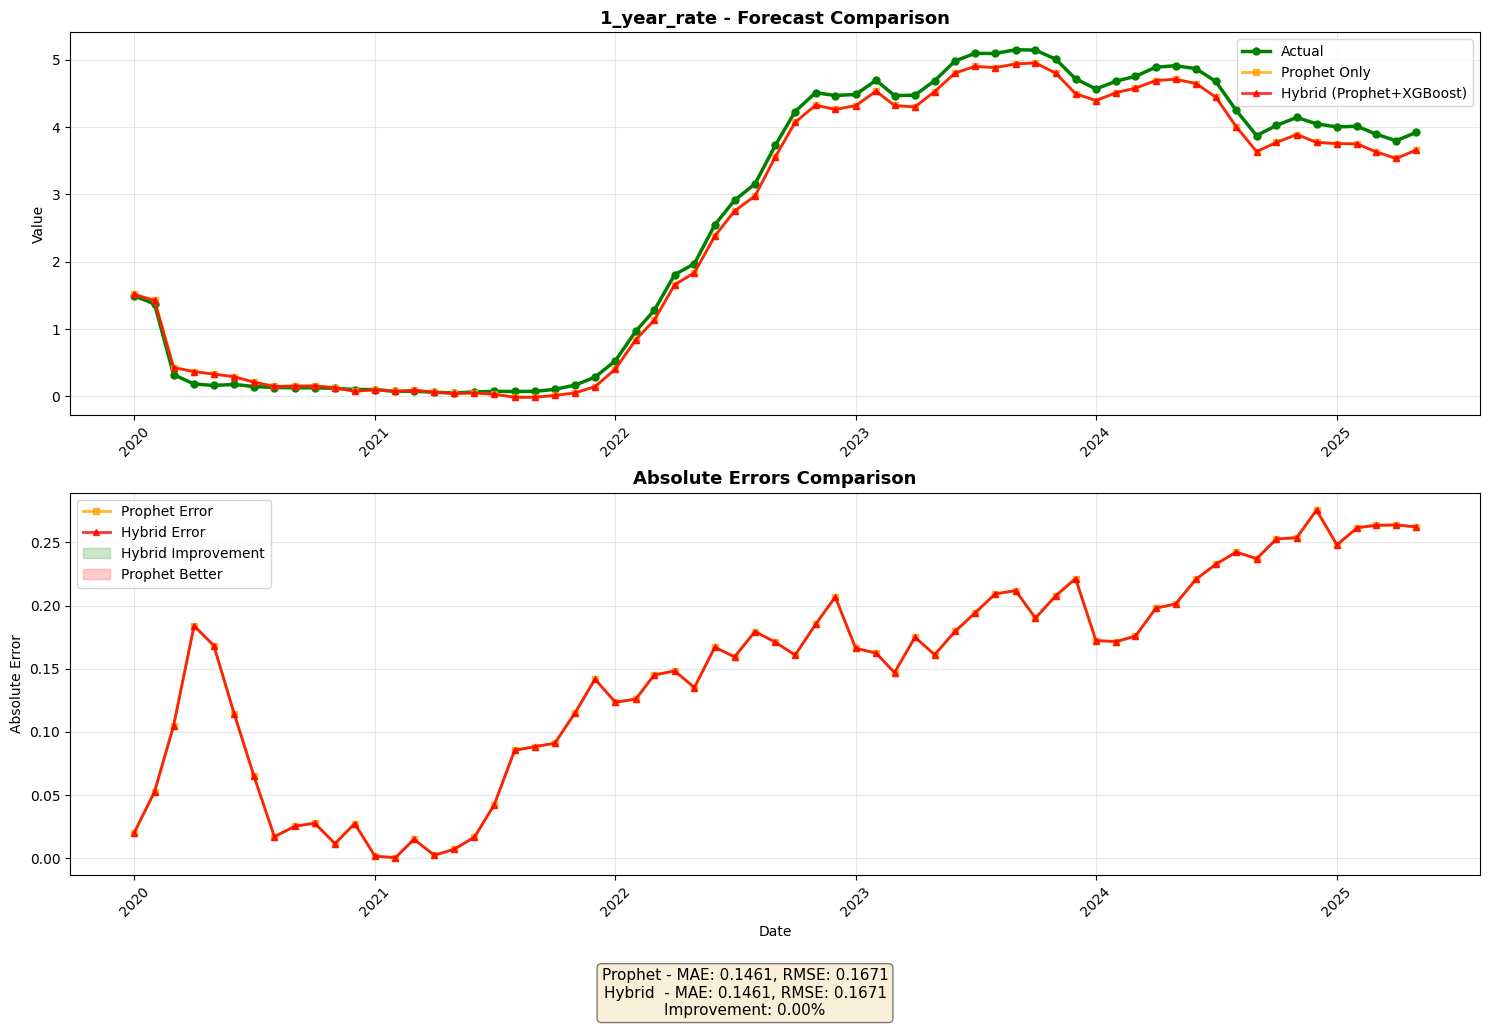

[I 2025-10-12 17:51:17,601] A new study created in memory with name: no-name-777ce192-0248-4220-97b9-e8eeefdaf5d9
17:51:17 - cmdstanpy - INFO - Chain [1] start processing



HYBRID FORECASTING: 3_months_rate
Series lengths - Train: 635, Test: 65

--- STEP 1: Training Prophet Model ---

Preparing exogenous features for 3_months_rate...
Available exogenous features: 29
Features: ['1_year_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for 3_months_rate...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Tuning Prophet with 20 trials...


17:51:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:51:18,181] Trial 0 finished with value: 0.030172498477492295 and parameters: {'changepoint_prior_scale': 0.03921416221405317, 'seasonality_prior_scale': 0.014786949694725098, 'holidays_prior_scale': 0.014889938033186237, 'seasonality_mode': 'additive', 'changepoint_range': 0.9353961697224416, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 0 with value: 0.030172498477492295.
17:51:18 - cmdstanpy - INFO - Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:51:18,861] Trial 1 finished with value: 0.03767374739171913 and parameters: {'changepoint_prior_scale': 0.0706153543305353, 'seasonality_prior_scale': 0.014226454627390537, 'holidays_prior_scale': 0.6732370311494965, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8244344085100588, 'yearly_seasonality': 'auto', 'weekly_seasonality': False}. Best is trial 0 with value: 0.03017249

Best Prophet params: {'changepoint_prior_scale': 0.0018361242607389738, 'seasonality_prior_scale': 0.06413167472754713, 'holidays_prior_scale': 0.4066582065944562, 'seasonality_mode': 'additive', 'changepoint_range': 0.947066053948599, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}


[I 2025-10-12 17:51:24,690] A new study created in memory with name: no-name-fd7d2f12-c2ab-4212-9a92-0d5a706bb473
[I 2025-10-12 17:51:24,876] Trial 0 finished with value: 0.01972725127802407 and parameters: {'max_depth': 8, 'learning_rate': 0.297260424516664, 'n_estimators': 79, 'subsample': 0.6635351925074817, 'colsample_bytree': 0.9818764138186852, 'reg_lambda': 0.7918767429554177, 'reg_alpha': 4.777666361514279}. Best is trial 0 with value: 0.01972725127802407.


Prophet MAE: 0.0332

--- STEP 2: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 17:51:25,823] Trial 1 finished with value: 0.012963170166295168 and parameters: {'max_depth': 6, 'learning_rate': 0.1262574234694492, 'n_estimators': 233, 'subsample': 0.7188417232677602, 'colsample_bytree': 0.8982614194945693, 'reg_lambda': 2.6439120301556716, 'reg_alpha': 0.3058171902688381}. Best is trial 1 with value: 0.012963170166295168.
[I 2025-10-12 17:51:27,509] Trial 2 finished with value: 0.0123037034737318 and parameters: {'max_depth': 6, 'learning_rate': 0.014499253674972465, 'n_estimators': 182, 'subsample': 0.655846800708201, 'colsample_bytree': 0.8703394799219142, 'reg_lambda': 0.15175380051175605, 'reg_alpha': 0.1292695575670818}. Best is trial 2 with value: 0.0123037034737318.
[I 2025-10-12 17:51:27,777] Trial 3 finished with value: 0.012149606719295738 and parameters: {'max_depth': 3, 'learning_rate': 0.2512272921009885, 'n_estimators': 124, 'subsample': 0.6837182164820954, 'colsample_bytree': 0.6927476490538391, 'reg_lambda': 0.47328711299998183, 'reg_

Best XGBoost params: {'max_depth': 3, 'learning_rate': 0.09017968041215561, 'n_estimators': 271, 'subsample': 0.7613680440893893, 'colsample_bytree': 0.8162111874226672, 'reg_lambda': 0.32134791515030153, 'reg_alpha': 0.265594601940034}
XGBoost Residual MAE: 0.0076

--- STEP 3: Making Hybrid Predictions ---

Test Metrics:
  Prophet     - MAE: 0.3240, RMSE: 0.3597, MAPE: 121.93%
  Hybrid      - MAE: 0.3261, RMSE: 0.3617, MAPE: 123.05%
  Improvement: -0.62%


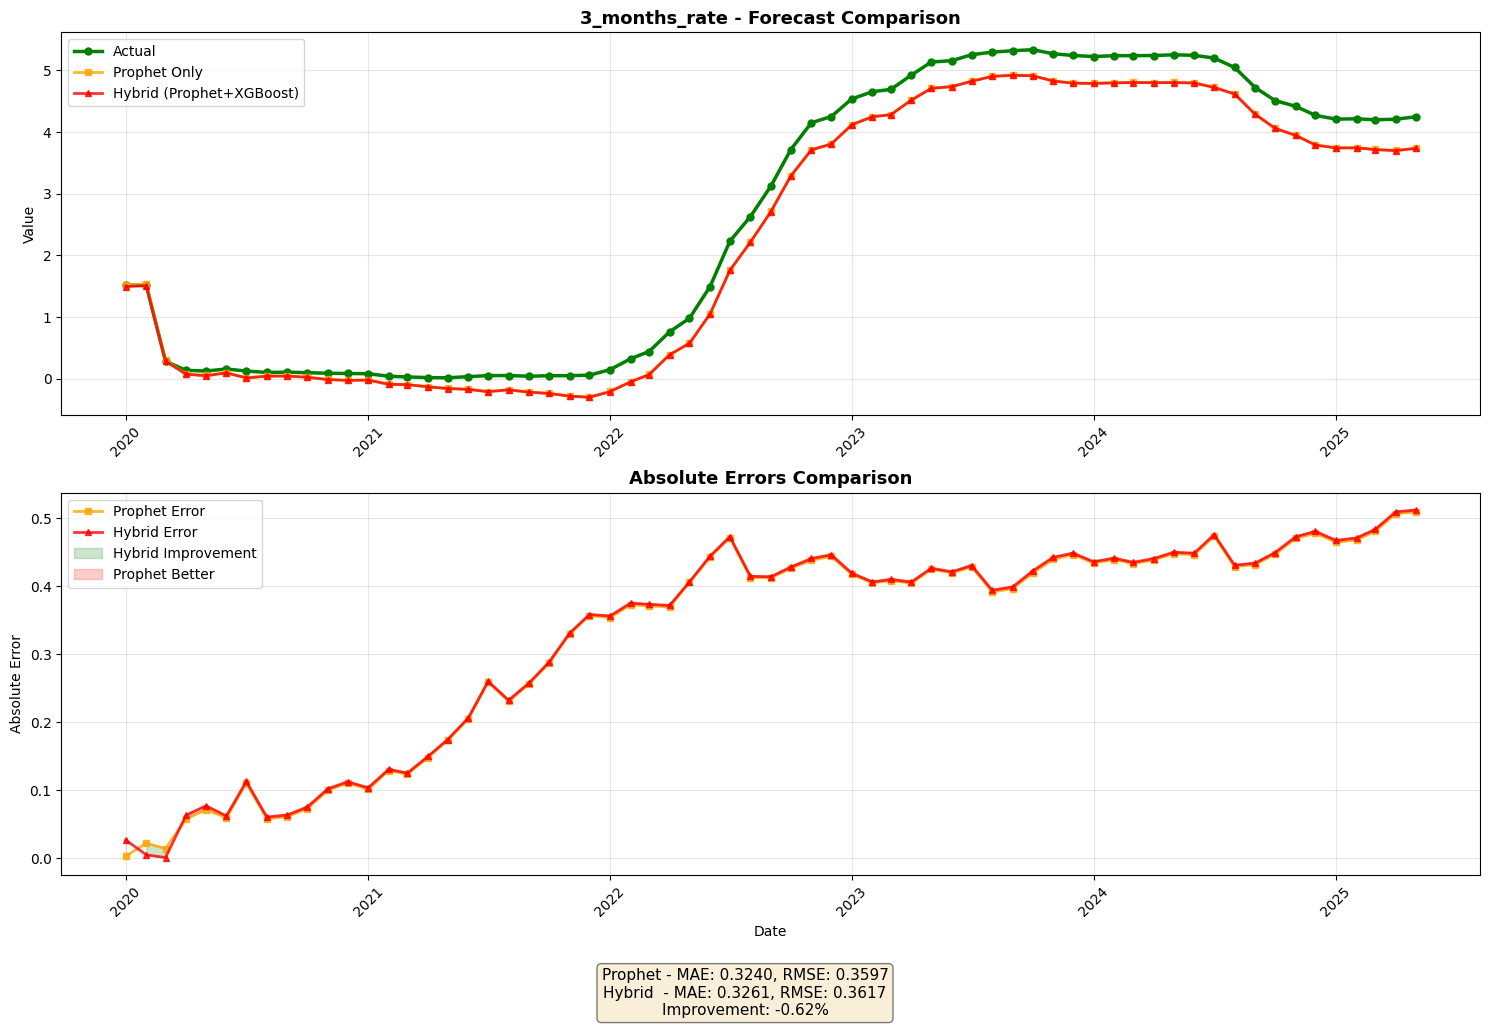

[I 2025-10-12 17:51:40,172] A new study created in memory with name: no-name-bbfd4855-bb5a-42cc-a42b-32a6591c0ffc
17:51:40 - cmdstanpy - INFO - Chain [1] start processing



HYBRID FORECASTING: 6_months_rate
Series lengths - Train: 635, Test: 65

--- STEP 1: Training Prophet Model ---

Preparing exogenous features for 6_months_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for 6_months_rate...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Tuning Prophet with 20 trials...


17:51:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:51:40,675] Trial 0 finished with value: 0.029160648493973314 and parameters: {'changepoint_prior_scale': 0.026940885803235826, 'seasonality_prior_scale': 0.32274851915304265, 'holidays_prior_scale': 0.5515147484473331, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8328793287983616, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.029160648493973314.
17:51:40 - cmdstanpy - INFO - Chain [1] start processing
17:51:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:51:41,225] Trial 1 finished with value: 0.030062266652730197 and parameters: {'changepoint_prior_scale': 0.005078446337708348, 'seasonality_prior_scale': 0.047264864482095915, 'holidays_prior_scale': 0.8035233231896347, 'seasonality_mode': 'additive', 'changepoint_range': 0.8188196463235823, 'yearly_seasonality': 'auto', 'weekly_seasonality': False}. Best is trial 0 with value: 0.02916

Best Prophet params: {'changepoint_prior_scale': 0.0011566048670645806, 'seasonality_prior_scale': 2.7137241332153628, 'holidays_prior_scale': 3.434503608872284, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8036995704458502, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}


[I 2025-10-12 17:51:47,855] A new study created in memory with name: no-name-7f9a7f14-94c4-44ff-b77e-c23fa8c22331


Prophet MAE: 0.0213

--- STEP 2: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 17:51:48,700] Trial 0 finished with value: 0.011313014965021764 and parameters: {'max_depth': 8, 'learning_rate': 0.054694923807415384, 'n_estimators': 200, 'subsample': 0.6063276568999728, 'colsample_bytree': 0.7762191428696078, 'reg_lambda': 0.2155691404113892, 'reg_alpha': 1.1169176366579476}. Best is trial 0 with value: 0.011313014965021764.
[I 2025-10-12 17:51:49,310] Trial 1 finished with value: 0.009386602480790863 and parameters: {'max_depth': 8, 'learning_rate': 0.08049969076798907, 'n_estimators': 59, 'subsample': 0.8168757053665916, 'colsample_bytree': 0.6276317153334684, 'reg_lambda': 0.19671080199294838, 'reg_alpha': 0.13610420176078342}. Best is trial 1 with value: 0.009386602480790863.
[I 2025-10-12 17:51:49,652] Trial 2 finished with value: 0.010790022081464812 and parameters: {'max_depth': 7, 'learning_rate': 0.2707109986765821, 'n_estimators': 159, 'subsample': 0.7882606046183894, 'colsample_bytree': 0.690893986603634, 'reg_lambda': 0.4612031353114445, '

Best XGBoost params: {'max_depth': 4, 'learning_rate': 0.04089351291672536, 'n_estimators': 162, 'subsample': 0.9202848384211773, 'colsample_bytree': 0.8938885458784284, 'reg_lambda': 1.0771982648035083, 'reg_alpha': 0.1903241056214185}
XGBoost Residual MAE: 0.0057

--- STEP 3: Making Hybrid Predictions ---

Test Metrics:
  Prophet     - MAE: 0.0732, RMSE: 0.0827, MAPE: 25.85%
  Hybrid      - MAE: 0.0755, RMSE: 0.0844, MAPE: 26.69%
  Improvement: -3.03%


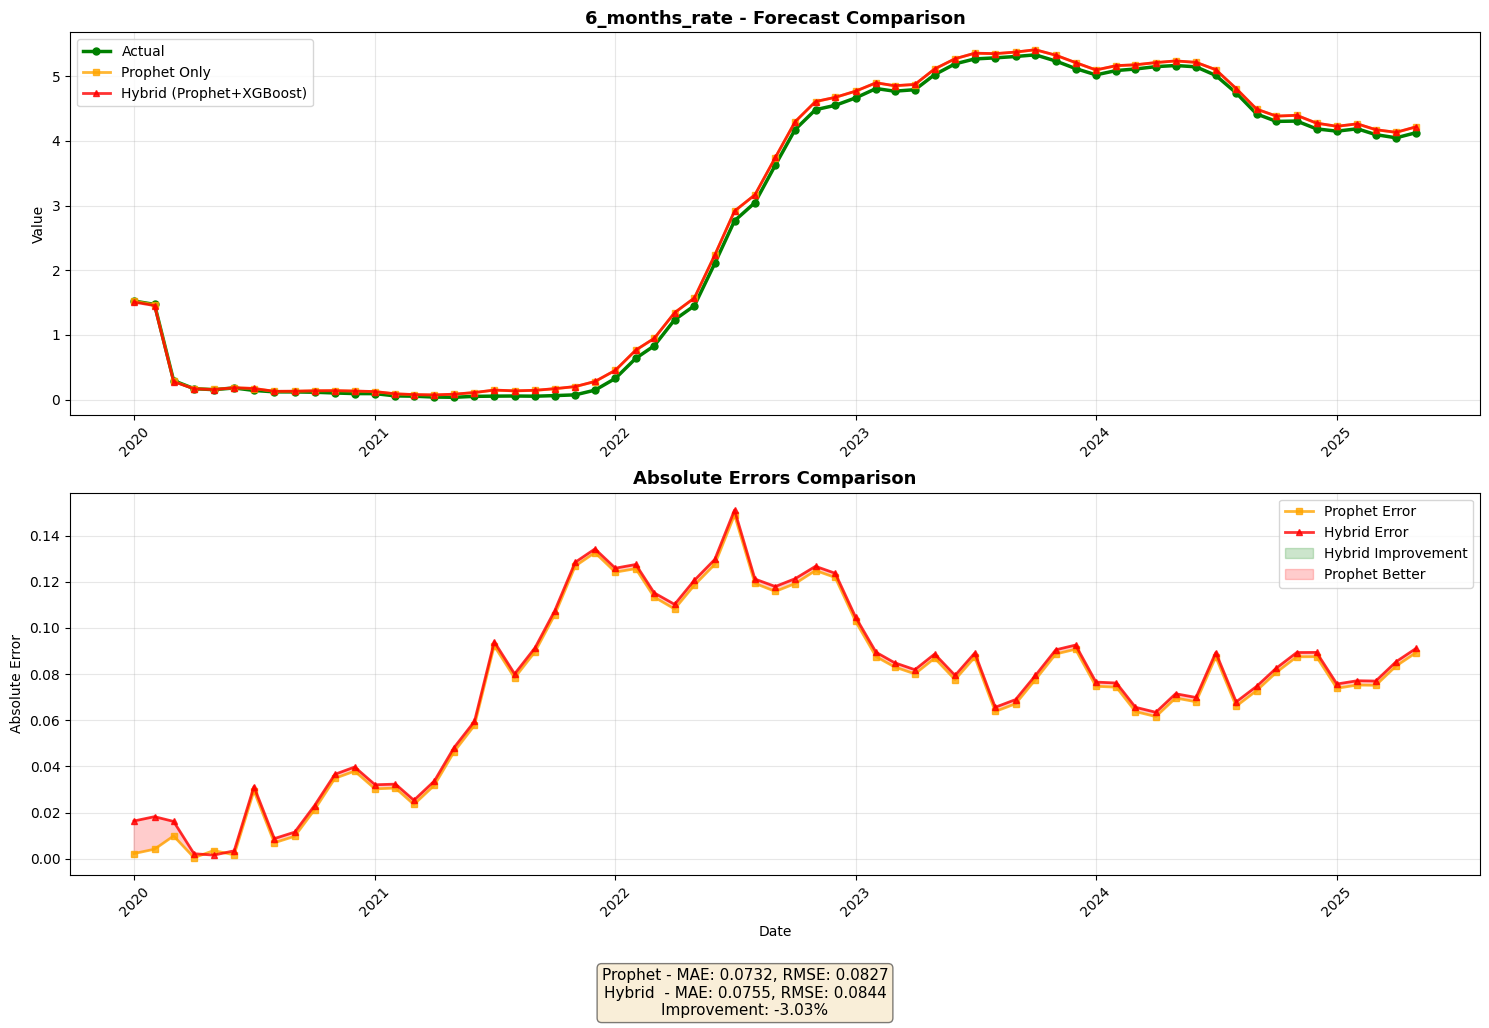

[I 2025-10-12 17:52:00,185] A new study created in memory with name: no-name-8295e575-3365-413a-8eb8-c5b507ae5aec
17:52:00 - cmdstanpy - INFO - Chain [1] start processing



HYBRID FORECASTING: CPI
Series lengths - Train: 635, Test: 65

--- STEP 1: Training Prophet Model ---

Preparing exogenous features for CPI...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for CPI...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Tuning Prophet with 20 trials...


17:52:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:52:01,035] Trial 0 finished with value: 0.477062734998248 and parameters: {'changepoint_prior_scale': 0.011656445653060976, 'seasonality_prior_scale': 0.4895084344524389, 'holidays_prior_scale': 0.010709783100837549, 'seasonality_mode': 'additive', 'changepoint_range': 0.8378491006452825, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 0 with value: 0.477062734998248.
17:52:01 - cmdstanpy - INFO - Chain [1] start processing
17:52:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:52:01,416] Trial 1 finished with value: 0.3890854041653813 and parameters: {'changepoint_prior_scale': 0.00714805836431238, 'seasonality_prior_scale': 0.1681252671945473, 'holidays_prior_scale': 2.31188742450282, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8170157727250471, 'yearly_seasonality': False, 'weekly_seasonality': False}. Best is trial 1 with value: 0.3890854041653813.
17:5

Best Prophet params: {'changepoint_prior_scale': 0.48902286412902934, 'seasonality_prior_scale': 0.07219981814388134, 'holidays_prior_scale': 8.96044515031745, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9190464670061753, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}


17:52:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:52:15,929] A new study created in memory with name: no-name-ffb5b8c6-d6fe-41c2-beb6-7f7867d4b5e2


Prophet MAE: 0.2679

--- STEP 2: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 17:52:17,519] Trial 0 finished with value: 0.3733906087096073 and parameters: {'max_depth': 8, 'learning_rate': 0.06379672768541528, 'n_estimators': 186, 'subsample': 0.9377969389909776, 'colsample_bytree': 0.6199365934688008, 'reg_lambda': 0.2511082902450987, 'reg_alpha': 1.3569185469148197}. Best is trial 0 with value: 0.3733906087096073.
[I 2025-10-12 17:52:18,467] Trial 1 finished with value: 0.32716631225530785 and parameters: {'max_depth': 4, 'learning_rate': 0.05466416761471725, 'n_estimators': 223, 'subsample': 0.7461543317113883, 'colsample_bytree': 0.9309012098458203, 'reg_lambda': 0.14022022065177514, 'reg_alpha': 2.7750457203630723}. Best is trial 1 with value: 0.32716631225530785.
[I 2025-10-12 17:52:19,925] Trial 2 finished with value: 0.296047331146935 and parameters: {'max_depth': 5, 'learning_rate': 0.03929555479886825, 'n_estimators': 229, 'subsample': 0.8308448015744088, 'colsample_bytree': 0.8857266948153528, 'reg_lambda': 2.9922330988742507, 'reg_alph

Best XGBoost params: {'max_depth': 5, 'learning_rate': 0.026858448350526247, 'n_estimators': 58, 'subsample': 0.8133290658424662, 'colsample_bytree': 0.9115496998252238, 'reg_lambda': 3.448434897908535, 'reg_alpha': 0.24540532875215026}
XGBoost Residual MAE: 0.1271

--- STEP 3: Making Hybrid Predictions ---

Test Metrics:
  Prophet     - MAE: 25.2010, RMSE: 31.3535, MAPE: 8.23%
  Hybrid      - MAE: 25.2283, RMSE: 31.3718, MAPE: 8.24%
  Improvement: -0.11%


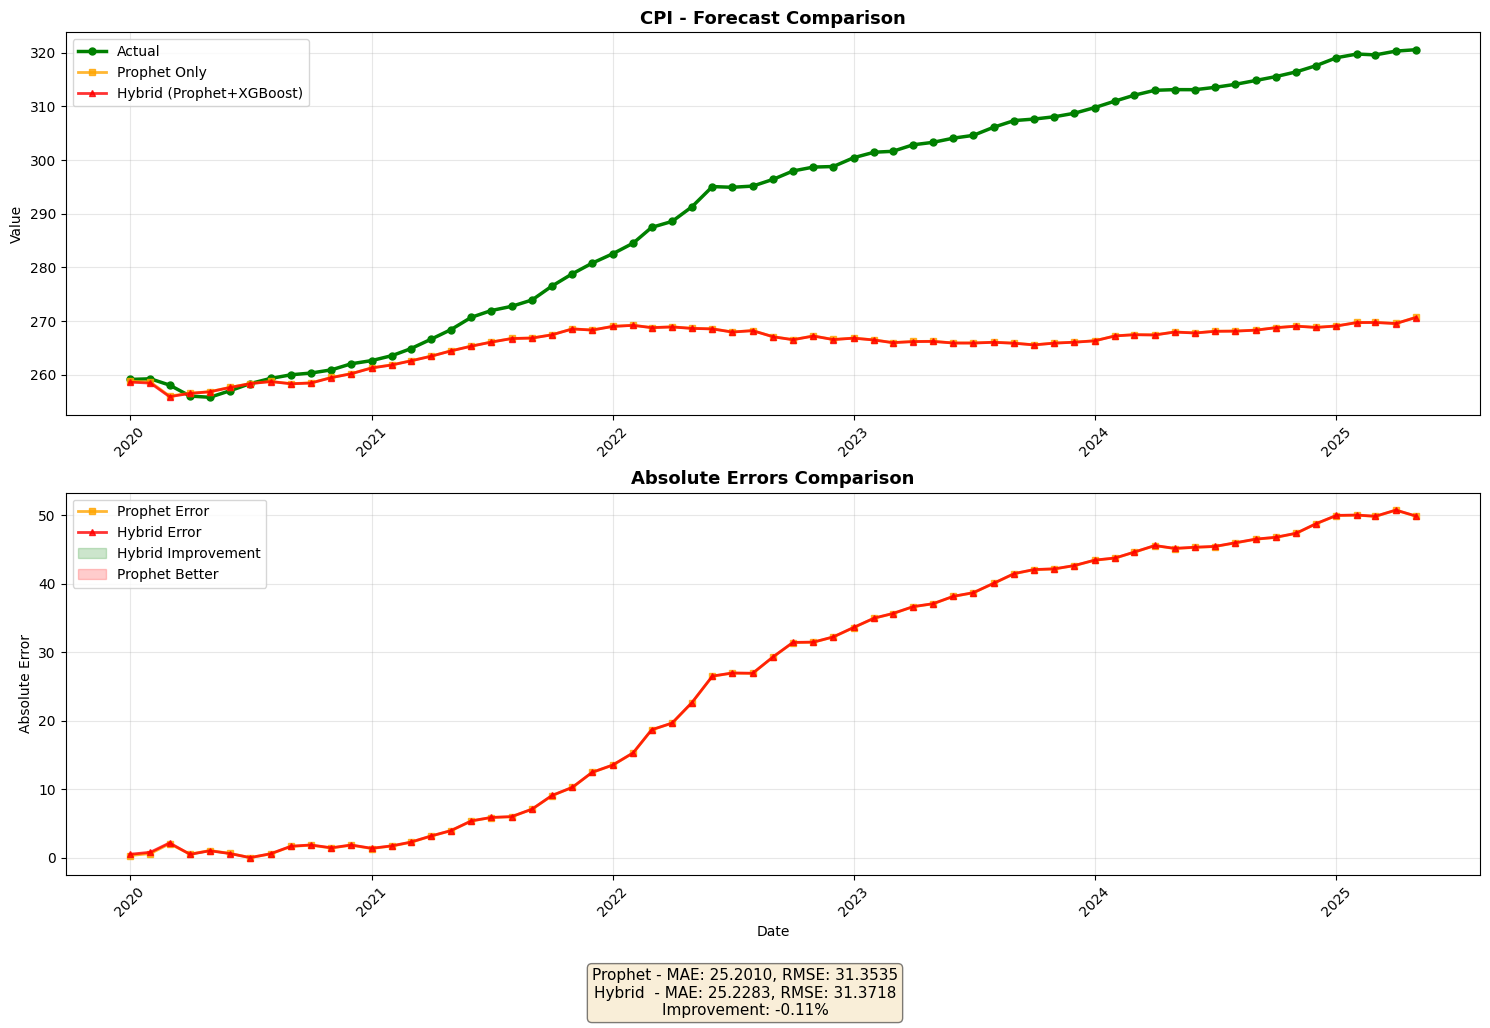

[I 2025-10-12 17:52:37,061] A new study created in memory with name: no-name-ff4f2f00-d0a9-4f2f-b04d-8eefe7996f2e
17:52:37 - cmdstanpy - INFO - Chain [1] start processing



HYBRID FORECASTING: INDPRO
Series lengths - Train: 635, Test: 65

--- STEP 1: Training Prophet Model ---

Preparing exogenous features for INDPRO...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for INDPRO...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Tuning Prophet with 20 trials...


17:52:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:52:37,526] Trial 0 finished with value: 0.4297155731921898 and parameters: {'changepoint_prior_scale': 0.007116743353250027, 'seasonality_prior_scale': 0.028787498689578268, 'holidays_prior_scale': 0.02020246928752678, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8206638703029178, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 0 with value: 0.4297155731921898.
17:52:37 - cmdstanpy - INFO - Chain [1] start processing
17:52:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:52:37,813] Trial 1 finished with value: 0.4160802161797259 and parameters: {'changepoint_prior_scale': 0.004830200219635709, 'seasonality_prior_scale': 8.462073408981283, 'holidays_prior_scale': 0.051042810943910964, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9408197092198485, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 1 with value: 0.41608021

Best Prophet params: {'changepoint_prior_scale': 0.4298691855806224, 'seasonality_prior_scale': 0.5729623681120376, 'holidays_prior_scale': 0.6738778773603086, 'seasonality_mode': 'additive', 'changepoint_range': 0.9033786185674377, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}


17:52:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:52:51,232] A new study created in memory with name: no-name-c3fe51c5-4097-4e32-ad7d-0399b7904628


Prophet MAE: 0.2340

--- STEP 2: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 17:52:52,052] Trial 0 finished with value: 0.21074106295310654 and parameters: {'max_depth': 5, 'learning_rate': 0.051136386820497925, 'n_estimators': 143, 'subsample': 0.876652961421329, 'colsample_bytree': 0.8223143619452407, 'reg_lambda': 0.8364740429215369, 'reg_alpha': 1.1761914158578053}. Best is trial 0 with value: 0.21074106295310654.
[I 2025-10-12 17:52:52,849] Trial 1 finished with value: 0.19077696031562177 and parameters: {'max_depth': 5, 'learning_rate': 0.16264780975477572, 'n_estimators': 157, 'subsample': 0.8522148368273215, 'colsample_bytree': 0.7664716060628202, 'reg_lambda': 0.9849029195952579, 'reg_alpha': 0.7359258469689823}. Best is trial 1 with value: 0.19077696031562177.
[I 2025-10-12 17:52:53,265] Trial 2 finished with value: 0.27279219678025285 and parameters: {'max_depth': 5, 'learning_rate': 0.02430407262073444, 'n_estimators': 70, 'subsample': 0.8810491700572528, 'colsample_bytree': 0.7031360622151885, 'reg_lambda': 0.4919907079444248, 'reg_al

Best XGBoost params: {'max_depth': 4, 'learning_rate': 0.23488221723684502, 'n_estimators': 299, 'subsample': 0.9900342653055448, 'colsample_bytree': 0.9899872657578898, 'reg_lambda': 0.1130412778545479, 'reg_alpha': 0.42844838704662397}
XGBoost Residual MAE: 0.0161

--- STEP 3: Making Hybrid Predictions ---

Test Metrics:
  Prophet     - MAE: 7.3688, RMSE: 8.1040, MAPE: 7.22%
  Hybrid      - MAE: 7.3834, RMSE: 8.1049, MAPE: 7.24%
  Improvement: -0.20%


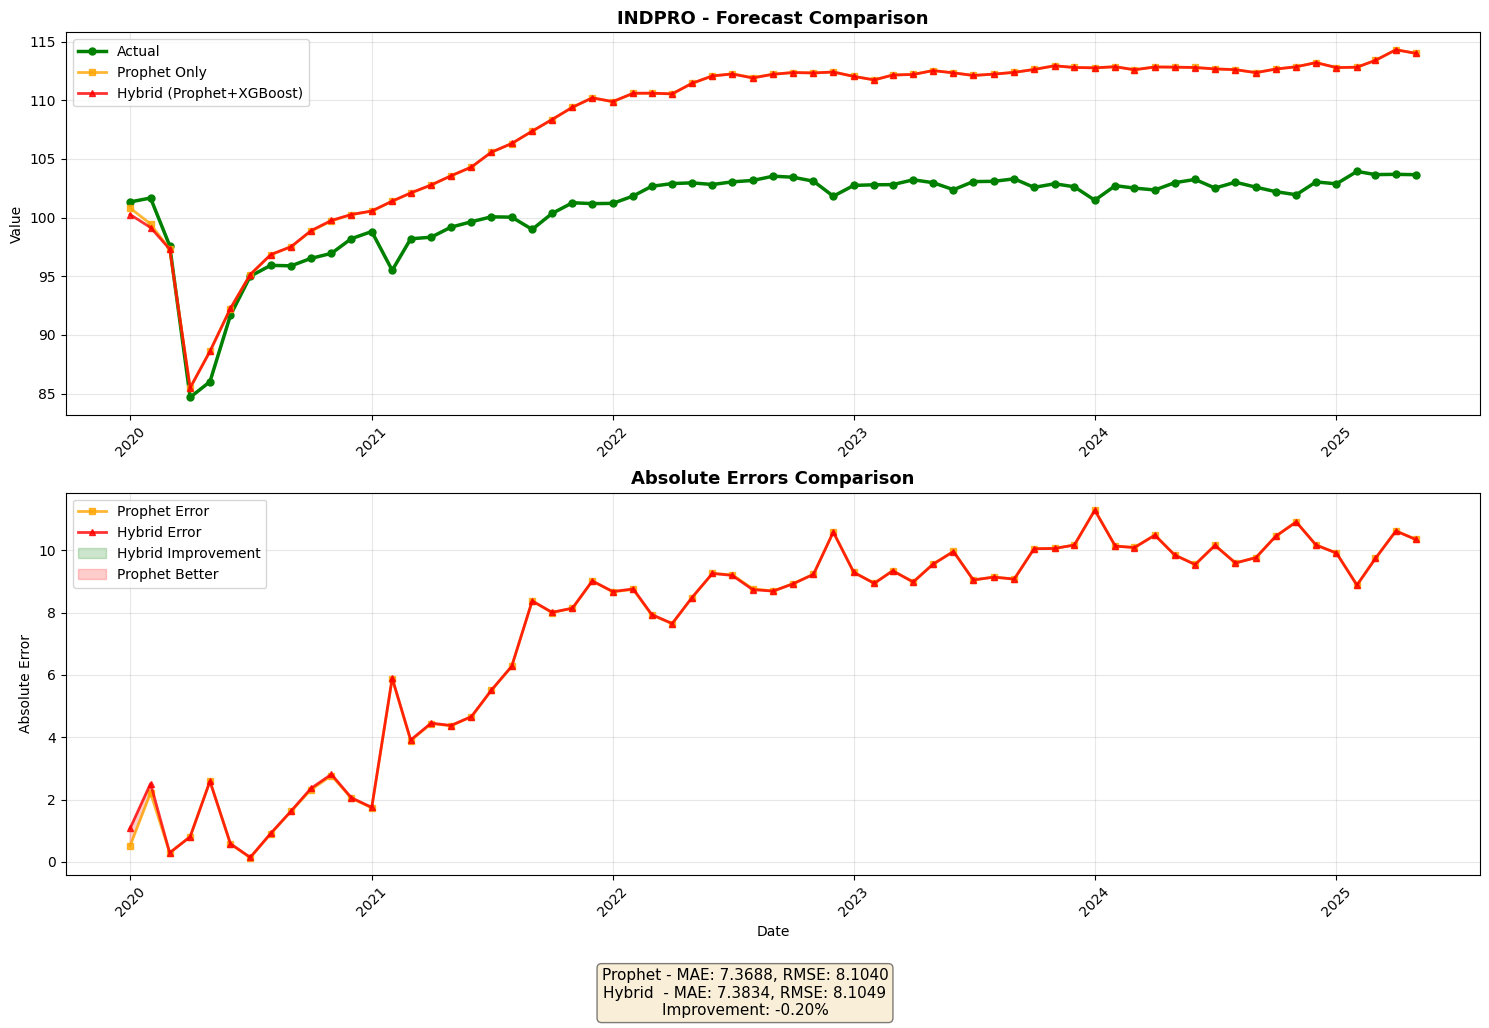

[I 2025-10-12 17:53:08,832] A new study created in memory with name: no-name-95c95343-c095-485c-8fac-738119fb195b
17:53:08 - cmdstanpy - INFO - Chain [1] start processing



HYBRID FORECASTING: 10_year_rate
Series lengths - Train: 635, Test: 65

--- STEP 1: Training Prophet Model ---

Preparing exogenous features for 10_year_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for 10_year_rate...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Tuning Prophet with 20 trials...


17:53:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:53:09,132] Trial 0 finished with value: 0.07467704402883596 and parameters: {'changepoint_prior_scale': 0.014380494341951964, 'seasonality_prior_scale': 2.0281896536475723, 'holidays_prior_scale': 5.633141176413357, 'seasonality_mode': 'additive', 'changepoint_range': 0.908077346080209, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 0 with value: 0.07467704402883596.
17:53:09 - cmdstanpy - INFO - Chain [1] start processing
17:53:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:53:09,582] Trial 1 finished with value: 0.0996378192722077 and parameters: {'changepoint_prior_scale': 0.3028420959275028, 'seasonality_prior_scale': 6.610333269730832, 'holidays_prior_scale': 0.03568719977460967, 'seasonality_mode': 'additive', 'changepoint_range': 0.9177025368717172, 'yearly_seasonality': 'auto', 'weekly_seasonality': False}. Best is trial 0 with value: 0.07467704402883596.
17:53:

Best Prophet params: {'changepoint_prior_scale': 0.0035560489861886004, 'seasonality_prior_scale': 0.21827476431829068, 'holidays_prior_scale': 0.7595897192949916, 'seasonality_mode': 'additive', 'changepoint_range': 0.8800018605584974, 'yearly_seasonality': False, 'weekly_seasonality': True}


[I 2025-10-12 17:53:14,974] A new study created in memory with name: no-name-0d51e9ef-2515-408e-88b3-fa3f379308b8


Prophet MAE: 0.0613

--- STEP 2: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 17:53:15,493] Trial 0 finished with value: 0.022406142902791984 and parameters: {'max_depth': 3, 'learning_rate': 0.259562569987548, 'n_estimators': 205, 'subsample': 0.9538268221817616, 'colsample_bytree': 0.6845400130390619, 'reg_lambda': 0.5350482248253775, 'reg_alpha': 0.3216747473175583}. Best is trial 0 with value: 0.022406142902791984.
[I 2025-10-12 17:53:15,983] Trial 1 finished with value: 0.01759758803479292 and parameters: {'max_depth': 3, 'learning_rate': 0.09717684029916863, 'n_estimators': 174, 'subsample': 0.9458116937110888, 'colsample_bytree': 0.9895104794735482, 'reg_lambda': 0.7592766364592569, 'reg_alpha': 0.21243387442523434}. Best is trial 1 with value: 0.01759758803479292.
[I 2025-10-12 17:53:16,473] Trial 2 finished with value: 0.02965973653056237 and parameters: {'max_depth': 6, 'learning_rate': 0.29183583104936783, 'n_estimators': 232, 'subsample': 0.9787174464171039, 'colsample_bytree': 0.9375626043377653, 'reg_lambda': 3.5721686647929634, 'reg_

Best XGBoost params: {'max_depth': 3, 'learning_rate': 0.09717684029916863, 'n_estimators': 174, 'subsample': 0.9458116937110888, 'colsample_bytree': 0.9895104794735482, 'reg_lambda': 0.7592766364592569, 'reg_alpha': 0.21243387442523434}
XGBoost Residual MAE: 0.0090

--- STEP 3: Making Hybrid Predictions ---

Test Metrics:
  Prophet     - MAE: 0.1517, RMSE: 0.1737, MAPE: 6.75%
  Hybrid      - MAE: 0.1527, RMSE: 0.1733, MAPE: 6.84%
  Improvement: -0.64%


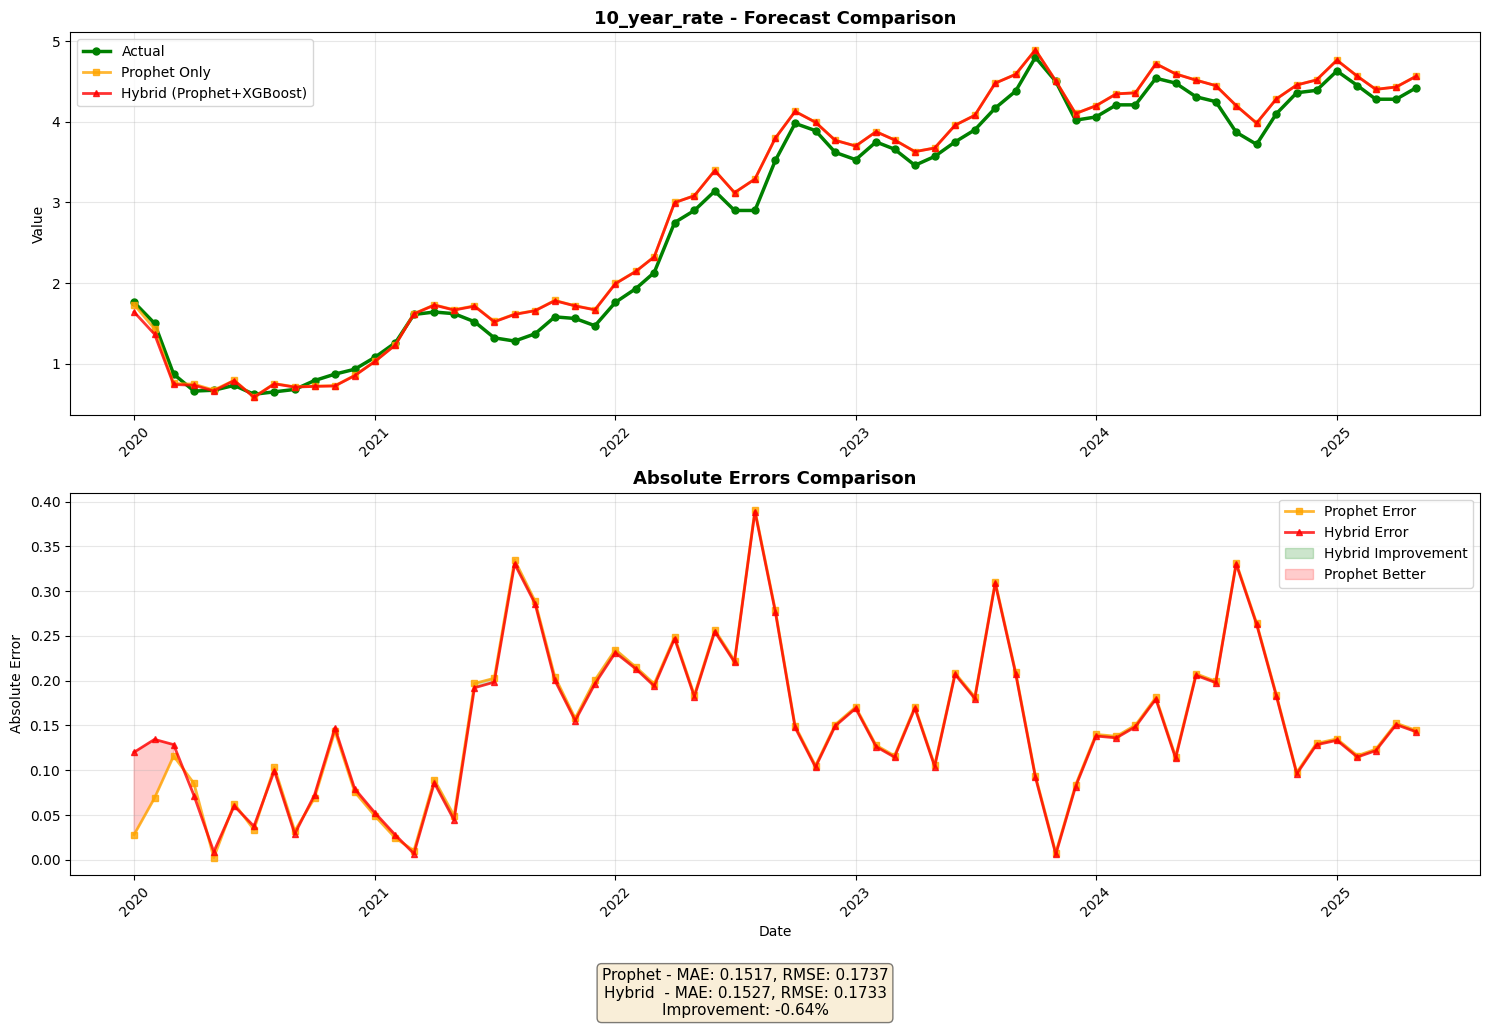

[I 2025-10-12 17:53:31,155] A new study created in memory with name: no-name-4689c4e5-78cb-4b34-b077-0509edbc0cd8
17:53:31 - cmdstanpy - INFO - Chain [1] start processing



HYBRID FORECASTING: share_price
Series lengths - Train: 635, Test: 65

--- STEP 1: Training Prophet Model ---

Preparing exogenous features for share_price...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for share_price...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Tuning Prophet with 20 trials...


17:53:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:53:31,448] Trial 0 finished with value: 2.7595212768349966 and parameters: {'changepoint_prior_scale': 0.009945355189698475, 'seasonality_prior_scale': 1.3145192283062248, 'holidays_prior_scale': 3.283710828902097, 'seasonality_mode': 'additive', 'changepoint_range': 0.8102115351459911, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 0 with value: 2.7595212768349966.
17:53:31 - cmdstanpy - INFO - Chain [1] start processing
17:53:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:53:31,600] Trial 1 finished with value: 2.953344680980262 and parameters: {'changepoint_prior_scale': 0.002776702102359832, 'seasonality_prior_scale': 0.6108352846315529, 'holidays_prior_scale': 0.5278961434569132, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8344725069791028, 'yearly_seasonality': False, 'weekly_seasonality': False}. Best is trial 0 with value: 2.7595212768349966.
17

Best Prophet params: {'changepoint_prior_scale': 0.21801809392826504, 'seasonality_prior_scale': 8.391742327772123, 'holidays_prior_scale': 6.684321743336648, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8884750534263259, 'yearly_seasonality': True, 'weekly_seasonality': True}


17:53:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:53:42,986] A new study created in memory with name: no-name-9a0d23e1-a7a9-4b25-b87f-55a3648a1797


Prophet MAE: 0.8012

--- STEP 2: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 17:53:44,042] Trial 0 finished with value: 1.5000243471132022 and parameters: {'max_depth': 7, 'learning_rate': 0.010953391558931798, 'n_estimators': 90, 'subsample': 0.7847646727070144, 'colsample_bytree': 0.7122164189006868, 'reg_lambda': 0.3511558466533227, 'reg_alpha': 1.2884888101811331}. Best is trial 0 with value: 1.5000243471132022.
[I 2025-10-12 17:53:45,172] Trial 1 finished with value: 1.2750649100904892 and parameters: {'max_depth': 7, 'learning_rate': 0.14290177015643782, 'n_estimators': 155, 'subsample': 0.8339436507011183, 'colsample_bytree': 0.9200671040280585, 'reg_lambda': 0.3998409378401427, 'reg_alpha': 2.4796129303350574}. Best is trial 1 with value: 1.2750649100904892.
[I 2025-10-12 17:53:48,040] Trial 2 finished with value: 1.2189833354842712 and parameters: {'max_depth': 8, 'learning_rate': 0.16830014740211088, 'n_estimators': 288, 'subsample': 0.6175629971844746, 'colsample_bytree': 0.9180079761574877, 'reg_lambda': 4.494142948697376, 'reg_alpha':

Best XGBoost params: {'max_depth': 4, 'learning_rate': 0.2943884659209874, 'n_estimators': 298, 'subsample': 0.8864117065784894, 'colsample_bytree': 0.997113727624617, 'reg_lambda': 0.22039840713481174, 'reg_alpha': 0.6101291127415571}
XGBoost Residual MAE: 0.0210

--- STEP 3: Making Hybrid Predictions ---

Test Metrics:
  Prophet     - MAE: 11.2883, RMSE: 13.6636, MAPE: 7.85%
  Hybrid      - MAE: 11.3672, RMSE: 13.6860, MAPE: 7.91%
  Improvement: -0.70%


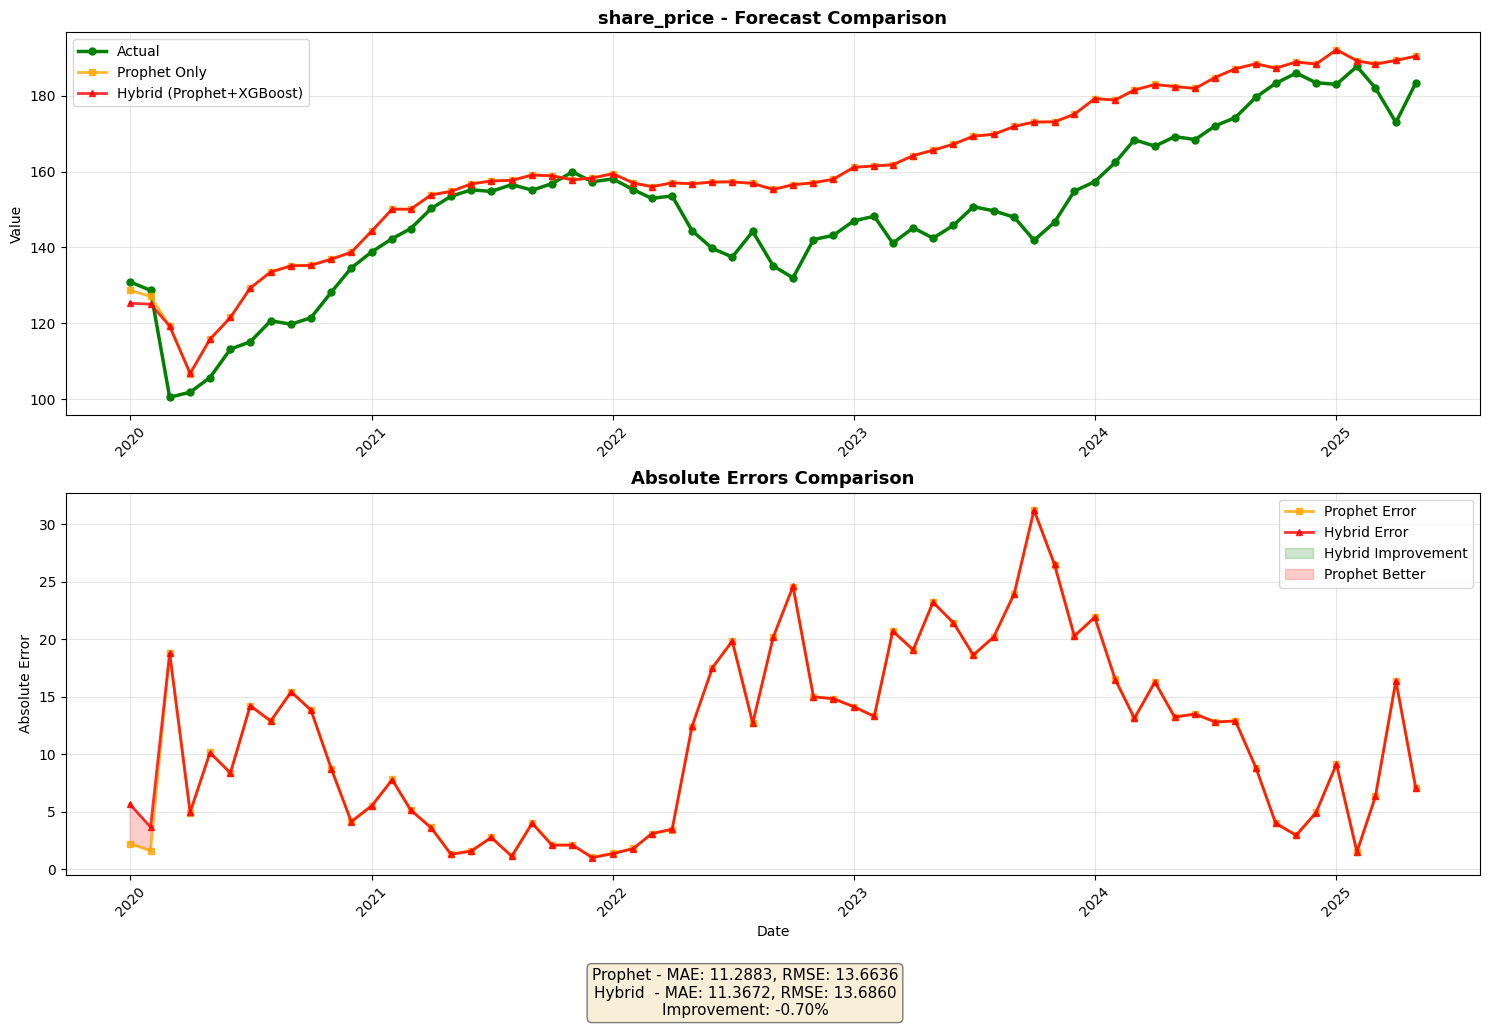

[I 2025-10-12 17:54:05,408] A new study created in memory with name: no-name-70bc07a5-aa0b-4533-b57b-0096e909234b
17:54:05 - cmdstanpy - INFO - Chain [1] start processing
17:54:05 - cmdstanpy - INFO - Chain [1] done processing



HYBRID FORECASTING: unemployment_rate
Series lengths - Train: 635, Test: 65

--- STEP 1: Training Prophet Model ---

Preparing exogenous features for unemployment_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for unemployment_rate...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Tuning Prophet with 20 trials...


[I 2025-10-12 17:54:05,607] Trial 0 finished with value: 0.10477676310791595 and parameters: {'changepoint_prior_scale': 0.021915256290691985, 'seasonality_prior_scale': 3.748450139437925, 'holidays_prior_scale': 4.807319981815156, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9381468855601718, 'yearly_seasonality': False, 'weekly_seasonality': False}. Best is trial 0 with value: 0.10477676310791595.
17:54:05 - cmdstanpy - INFO - Chain [1] start processing
17:54:05 - cmdstanpy - INFO - Chain [1] done processing
17:54:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:54:05 - cmdstanpy - INFO - Chain [1] start processing
17:54:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:54:07,532] Trial 1 finished with value: 0.10864024587571108 and parameters: {'changepoint_prior_scale': 0.0010280737444543395, 'seasonality_prior_scale': 1.6633907734295774, 'holiday

Best Prophet params: {'changepoint_prior_scale': 0.007396809840570282, 'seasonality_prior_scale': 0.011572192629850453, 'holidays_prior_scale': 0.010625843789871603, 'seasonality_mode': 'additive', 'changepoint_range': 0.84582406224464, 'yearly_seasonality': 'auto', 'weekly_seasonality': False}


[I 2025-10-12 17:54:12,685] A new study created in memory with name: no-name-7de61b93-a38e-4e14-814b-00fab7bb2408


Prophet MAE: 0.0975

--- STEP 2: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 17:54:13,484] Trial 0 finished with value: 0.07167330243258993 and parameters: {'max_depth': 3, 'learning_rate': 0.028068559535258306, 'n_estimators': 286, 'subsample': 0.8687745398112052, 'colsample_bytree': 0.8408522452054422, 'reg_lambda': 1.3790766200519793, 'reg_alpha': 1.453954756526786}. Best is trial 0 with value: 0.07167330243258993.
[I 2025-10-12 17:54:14,249] Trial 1 finished with value: 0.06246177607485609 and parameters: {'max_depth': 3, 'learning_rate': 0.029781357683126005, 'n_estimators': 274, 'subsample': 0.8005754611994746, 'colsample_bytree': 0.8367544551700025, 'reg_lambda': 0.6859484511367729, 'reg_alpha': 0.4447910747786458}. Best is trial 1 with value: 0.06246177607485609.
[I 2025-10-12 17:54:15,540] Trial 2 finished with value: 0.05771610250031363 and parameters: {'max_depth': 5, 'learning_rate': 0.04548776037469128, 'n_estimators': 194, 'subsample': 0.903273829764309, 'colsample_bytree': 0.9264451433175972, 'reg_lambda': 0.3792802508781887, 'reg_a

Best XGBoost params: {'max_depth': 4, 'learning_rate': 0.1134295107558998, 'n_estimators': 147, 'subsample': 0.8644089533175658, 'colsample_bytree': 0.9561776142057696, 'reg_lambda': 0.41562953120763746, 'reg_alpha': 0.1802048179428209}
XGBoost Residual MAE: 0.0090

--- STEP 3: Making Hybrid Predictions ---

Test Metrics:
  Prophet     - MAE: 2.1051, RMSE: 2.6609, MAPE: 40.07%
  Hybrid      - MAE: 2.1178, RMSE: 2.6721, MAPE: 40.37%
  Improvement: -0.61%


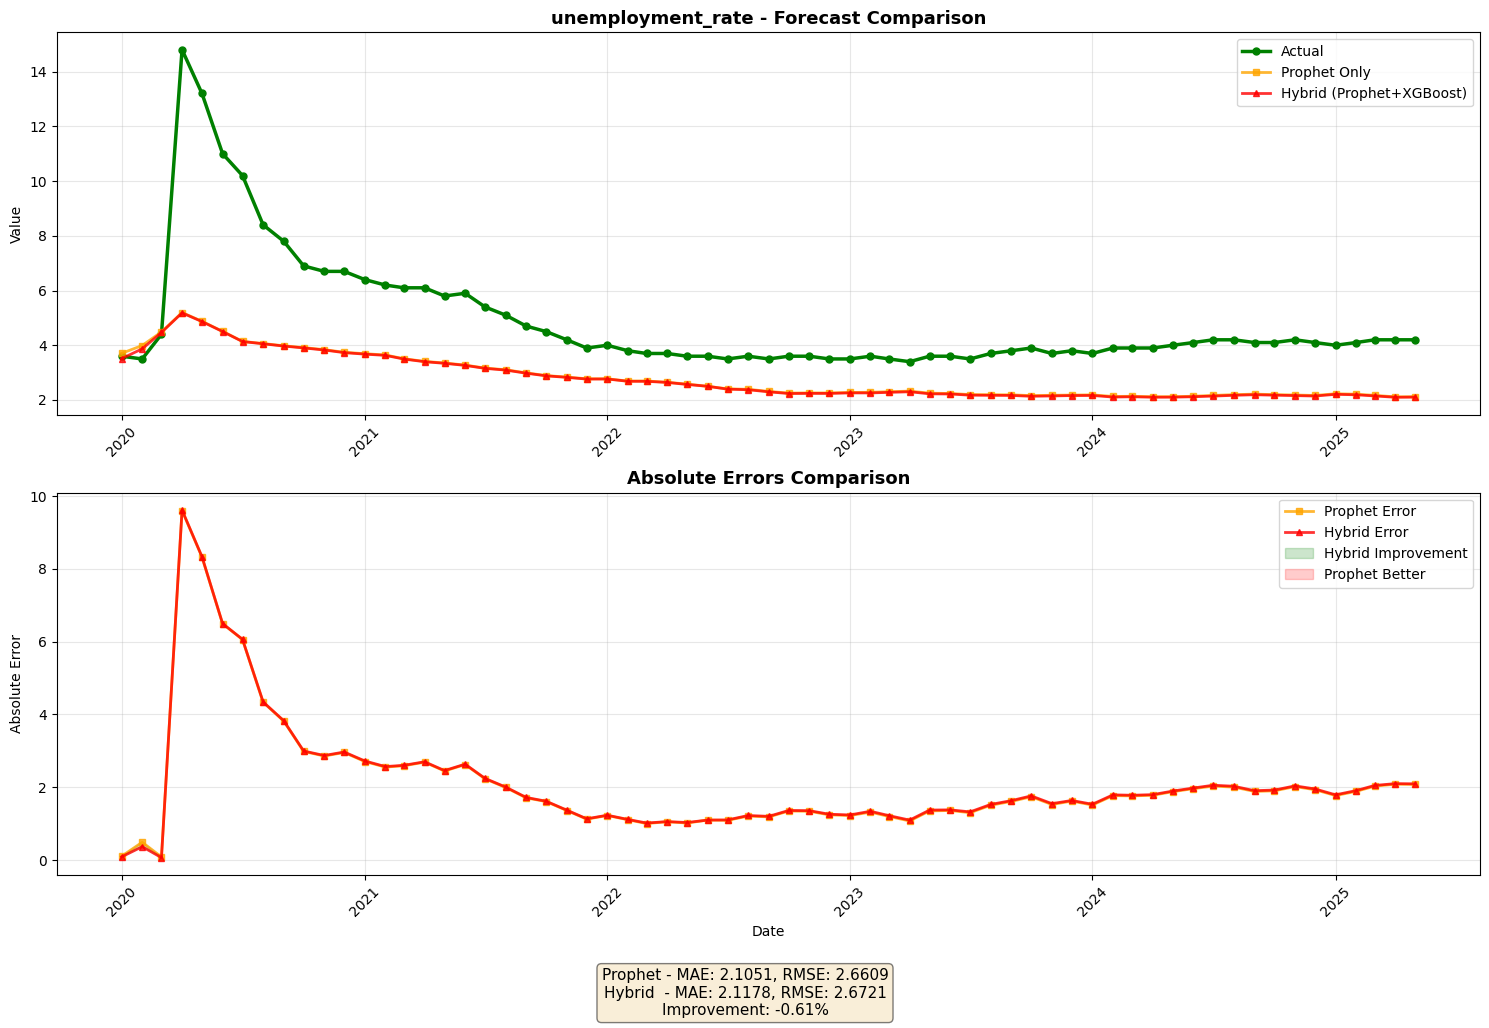

[I 2025-10-12 17:54:36,344] A new study created in memory with name: no-name-6c198723-a0a3-4feb-80fb-a2cad0f04b79
17:54:36 - cmdstanpy - INFO - Chain [1] start processing



HYBRID FORECASTING: PPI
Series lengths - Train: 635, Test: 65

--- STEP 1: Training Prophet Model ---

Preparing exogenous features for PPI...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for PPI...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Tuning Prophet with 20 trials...


17:54:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:54:36,649] Trial 0 finished with value: 5.14019448982342 and parameters: {'changepoint_prior_scale': 0.005737193255606354, 'seasonality_prior_scale': 0.05584573166241766, 'holidays_prior_scale': 1.4588129939347778, 'seasonality_mode': 'additive', 'changepoint_range': 0.8070393088541654, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 5.14019448982342.
17:54:36 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:54:37,371] Trial 1 finished with value: 3.995579551519517 and parameters: {'changepoint_prior_scale': 0.07683898320776412, 'seasonality_prior_scale': 0.013085181672900986, 'holidays_prior_scale': 5.40324734438347, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9271132417112544, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 1 with value: 3.995579551519517.
17:54

Best Prophet params: {'changepoint_prior_scale': 0.3076182473405157, 'seasonality_prior_scale': 5.31173759677878, 'holidays_prior_scale': 0.09010987750497776, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8183274786546257, 'yearly_seasonality': 'auto', 'weekly_seasonality': False}


17:54:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:54:45,571] A new study created in memory with name: no-name-86a552ed-d1cf-4113-b1df-38c8698dbafa


Prophet MAE: 2.5821

--- STEP 2: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 17:54:47,773] Trial 0 finished with value: 5.708991085812643 and parameters: {'max_depth': 6, 'learning_rate': 0.05267491063609415, 'n_estimators': 261, 'subsample': 0.8534453501495736, 'colsample_bytree': 0.6055180333755971, 'reg_lambda': 0.172089105059332, 'reg_alpha': 0.2033184767311184}. Best is trial 0 with value: 5.708991085812643.
[I 2025-10-12 17:54:50,456] Trial 1 finished with value: 5.4681321746896465 and parameters: {'max_depth': 7, 'learning_rate': 0.015545481313625273, 'n_estimators': 196, 'subsample': 0.9641750175768075, 'colsample_bytree': 0.8619876149617252, 'reg_lambda': 0.30095273765016695, 'reg_alpha': 0.15888316016315163}. Best is trial 1 with value: 5.4681321746896465.
[I 2025-10-12 17:54:51,358] Trial 2 finished with value: 4.8908836627936045 and parameters: {'max_depth': 6, 'learning_rate': 0.1361497584595765, 'n_estimators': 107, 'subsample': 0.8817685316854343, 'colsample_bytree': 0.7688647741808543, 'reg_lambda': 2.027361365308143, 'reg_alpha': 

Best XGBoost params: {'max_depth': 3, 'learning_rate': 0.09825494458262062, 'n_estimators': 270, 'subsample': 0.9108977670517397, 'colsample_bytree': 0.9698128975134744, 'reg_lambda': 3.1051503988293034, 'reg_alpha': 1.7025004174831104}
XGBoost Residual MAE: 0.2009

--- STEP 3: Making Hybrid Predictions ---

Test Metrics:
  Prophet     - MAE: 152.2293, RMSE: 168.9373, MAPE: 30.46%
  Hybrid      - MAE: 152.3258, RMSE: 168.8645, MAPE: 30.51%
  Improvement: -0.06%


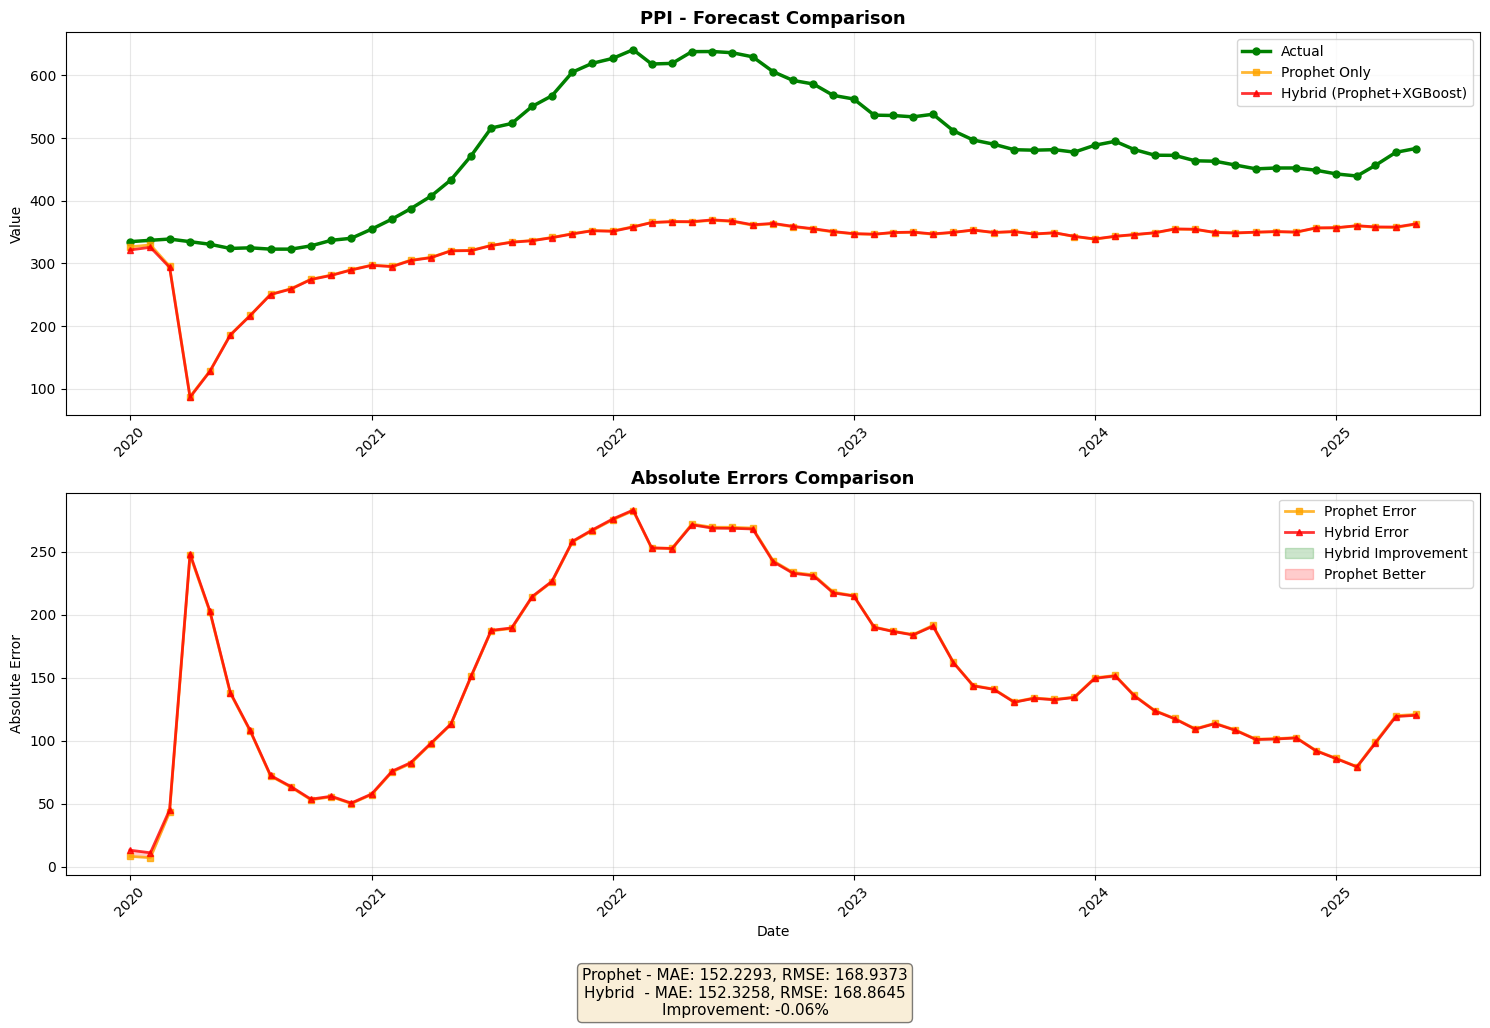

[I 2025-10-12 17:55:12,011] A new study created in memory with name: no-name-905281fe-f2d7-4bfb-8657-29d31d48c2cf
17:55:12 - cmdstanpy - INFO - Chain [1] start processing



HYBRID FORECASTING: OECD_CLI_index
Series lengths - Train: 635, Test: 65

--- STEP 1: Training Prophet Model ---

Preparing exogenous features for OECD_CLI_index...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'CSI_index']...
Cleaning Prophet data for OECD_CLI_index...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Tuning Prophet with 20 trials...


17:55:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:55:12,266] Trial 0 finished with value: 0.04266536488143743 and parameters: {'changepoint_prior_scale': 0.002315451550494061, 'seasonality_prior_scale': 0.3921471299227909, 'holidays_prior_scale': 0.26905120845816094, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9324044928956978, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 0 with value: 0.04266536488143743.
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:55:12,650] Trial 1 finished with value: 0.044313332003082066 and parameters: {'changepoint_prior_scale': 0.0018706330738000126, 'seasonality_prior_scale': 0.017008676265825744, 'holidays_prior_scale': 0.5043890336567819, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8478184108025872, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.042

Best Prophet params: {'changepoint_prior_scale': 0.001201332633326657, 'seasonality_prior_scale': 9.822959948279667, 'holidays_prior_scale': 0.01337175805786362, 'seasonality_mode': 'additive', 'changepoint_range': 0.9099496995403396, 'yearly_seasonality': False, 'weekly_seasonality': True}


[I 2025-10-12 17:55:22,974] A new study created in memory with name: no-name-f788cb19-3c98-41fa-9a6b-3b38dca20943


Prophet MAE: 0.0446

--- STEP 2: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 17:55:23,327] Trial 0 finished with value: 0.029557158539145707 and parameters: {'max_depth': 5, 'learning_rate': 0.10051685560443535, 'n_estimators': 97, 'subsample': 0.880925040407853, 'colsample_bytree': 0.925107691462777, 'reg_lambda': 0.1943356664648933, 'reg_alpha': 3.0882727429627117}. Best is trial 0 with value: 0.029557158539145707.
[I 2025-10-12 17:55:23,636] Trial 1 finished with value: 0.028215372851710455 and parameters: {'max_depth': 5, 'learning_rate': 0.21894539055570558, 'n_estimators': 169, 'subsample': 0.9722302458928052, 'colsample_bytree': 0.8437687117747923, 'reg_lambda': 0.12284542607468887, 'reg_alpha': 1.4117232675043452}. Best is trial 1 with value: 0.028215372851710455.
[I 2025-10-12 17:55:24,392] Trial 2 finished with value: 0.030899162878037203 and parameters: {'max_depth': 8, 'learning_rate': 0.19293405874861455, 'n_estimators': 265, 'subsample': 0.8544449070327094, 'colsample_bytree': 0.9947852076766296, 'reg_lambda': 1.0823578571352825, 're

Best XGBoost params: {'max_depth': 4, 'learning_rate': 0.07115009616729509, 'n_estimators': 186, 'subsample': 0.7853302909248546, 'colsample_bytree': 0.7733714324239446, 'reg_lambda': 0.38526727069076433, 'reg_alpha': 0.2611507992083892}
XGBoost Residual MAE: 0.0086

--- STEP 3: Making Hybrid Predictions ---

Test Metrics:
  Prophet     - MAE: 0.1732, RMSE: 0.1982, MAPE: 0.17%
  Hybrid      - MAE: 0.1757, RMSE: 0.2024, MAPE: 0.18%
  Improvement: -1.41%


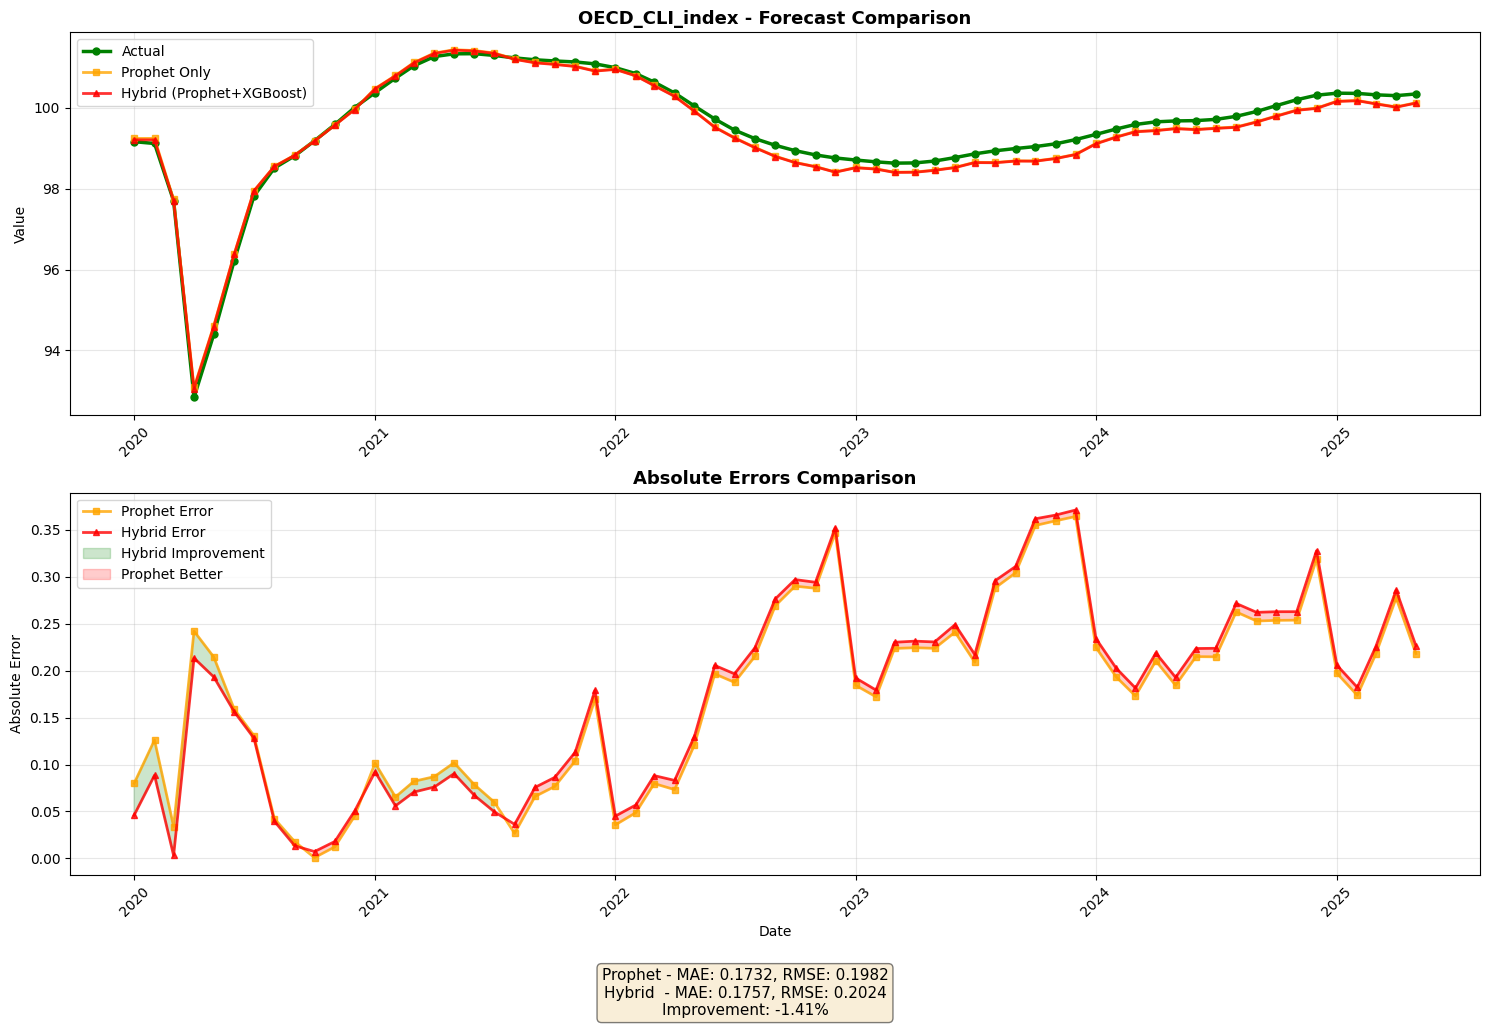

[I 2025-10-12 17:55:40,273] A new study created in memory with name: no-name-cac7d1f3-fd7c-44e9-a7ec-f8ede7f1a8d1
17:55:40 - cmdstanpy - INFO - Chain [1] start processing



HYBRID FORECASTING: CSI_index
Series lengths - Train: 635, Test: 65

--- STEP 1: Training Prophet Model ---

Preparing exogenous features for CSI_index...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index']...
Cleaning Prophet data for CSI_index...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Tuning Prophet with 20 trials...


17:55:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:55:40,594] Trial 0 finished with value: 2.5597885366850175 and parameters: {'changepoint_prior_scale': 0.11918115646944792, 'seasonality_prior_scale': 0.2577792176453585, 'holidays_prior_scale': 0.10506220024400927, 'seasonality_mode': 'additive', 'changepoint_range': 0.8533314953231248, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 2.5597885366850175.
17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:55:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:55:40,844] Trial 1 finished with value: 2.8142255068221416 and parameters: {'changepoint_prior_scale': 0.04254237423401262, 'seasonality_prior_scale': 0.24706546944357352, 'holidays_prior_scale': 2.803472623843388, 'seasonality_mode': 'additive', 'changepoint_range': 0.836557278448265, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 0 with value: 2.5597885366850175.
17:55:4

Best Prophet params: {'changepoint_prior_scale': 0.011265358842239528, 'seasonality_prior_scale': 0.5920083403979938, 'holidays_prior_scale': 0.6605738965122893, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8177346010986813, 'yearly_seasonality': False, 'weekly_seasonality': True}


[I 2025-10-12 17:55:45,969] A new study created in memory with name: no-name-a0862ea3-7e73-421e-8f7e-801a68bad424


Prophet MAE: 2.4352

--- STEP 2: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 17:55:46,793] Trial 0 finished with value: 1.2332779411100474 and parameters: {'max_depth': 7, 'learning_rate': 0.07441202491540322, 'n_estimators': 52, 'subsample': 0.816214700309581, 'colsample_bytree': 0.9923533408618026, 'reg_lambda': 0.3554570321671622, 'reg_alpha': 0.14752386489374764}. Best is trial 0 with value: 1.2332779411100474.
[I 2025-10-12 17:55:47,388] Trial 1 finished with value: 1.943814053602754 and parameters: {'max_depth': 6, 'learning_rate': 0.028311430319158275, 'n_estimators': 55, 'subsample': 0.8810028633745497, 'colsample_bytree': 0.7170414040681968, 'reg_lambda': 0.5165402103982325, 'reg_alpha': 0.16356540406591136}. Best is trial 0 with value: 1.2332779411100474.
[I 2025-10-12 17:55:47,970] Trial 2 finished with value: 1.4113919666971402 and parameters: {'max_depth': 5, 'learning_rate': 0.21869286897958384, 'n_estimators': 87, 'subsample': 0.6783070708420472, 'colsample_bytree': 0.8339508512503458, 'reg_lambda': 4.376080903613606, 'reg_alpha': 3

Best XGBoost params: {'max_depth': 3, 'learning_rate': 0.15982432991313694, 'n_estimators': 117, 'subsample': 0.641936070935601, 'colsample_bytree': 0.9750727780602704, 'reg_lambda': 0.9386735784909914, 'reg_alpha': 1.107611152021137}
XGBoost Residual MAE: 0.2479

--- STEP 3: Making Hybrid Predictions ---

Test Metrics:
  Prophet     - MAE: 20.2434, RMSE: 21.8902, MAPE: 30.63%
  Hybrid      - MAE: 20.3310, RMSE: 21.9383, MAPE: 30.73%
  Improvement: -0.43%


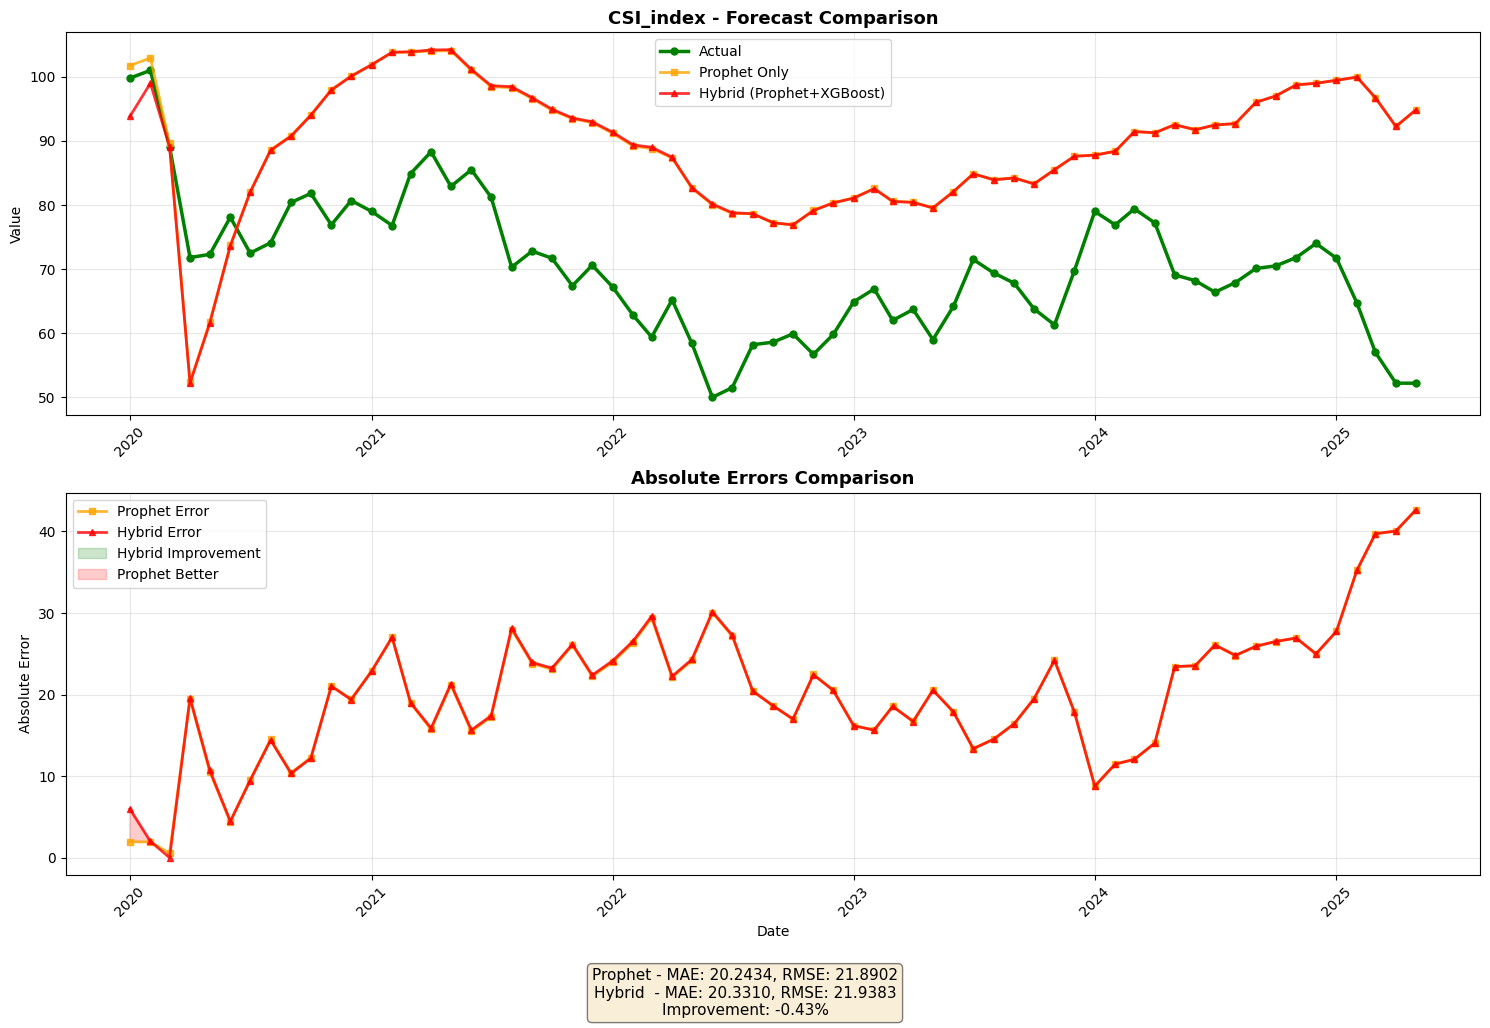

[I 2025-10-12 17:56:06,688] A new study created in memory with name: no-name-2b080be7-b79f-4b91-bc35-7559e96f5e0c
17:56:06 - cmdstanpy - INFO - Chain [1] start processing



HYBRID FORECASTING: gdp_per_capita
Series lengths - Train: 635, Test: 64

--- STEP 1: Training Prophet Model ---

Preparing exogenous features for gdp_per_capita...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index']...
Cleaning Prophet data for gdp_per_capita...
  Train shape: (635, 31), Test shape: (64, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Tuning Prophet with 20 trials...


17:56:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:56:07,637] Trial 0 finished with value: 67.62149667759965 and parameters: {'changepoint_prior_scale': 0.11704135394517083, 'seasonality_prior_scale': 0.09126924001759305, 'holidays_prior_scale': 0.01720132717358239, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8505871738591964, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 0 with value: 67.62149667759965.
17:56:07 - cmdstanpy - INFO - Chain [1] start processing
17:56:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:56:08,703] Trial 1 finished with value: 71.15174172432002 and parameters: {'changepoint_prior_scale': 0.0580689256052645, 'seasonality_prior_scale': 0.011474476875923043, 'holidays_prior_scale': 0.11572229955759998, 'seasonality_mode': 'additive', 'changepoint_range': 0.8899847990479438, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 0 with value: 67.62149667759965.
17:

Best Prophet params: {'changepoint_prior_scale': 0.11704135394517083, 'seasonality_prior_scale': 0.09126924001759305, 'holidays_prior_scale': 0.01720132717358239, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8505871738591964, 'yearly_seasonality': True, 'weekly_seasonality': False}


17:56:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-12 17:56:27,276] A new study created in memory with name: no-name-984ba80b-fd7d-4428-8aef-995a265ef4c8


Prophet MAE: 21.0944

--- STEP 2: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 17:56:29,263] Trial 0 finished with value: 26.59866185893184 and parameters: {'max_depth': 7, 'learning_rate': 0.015958956135196673, 'n_estimators': 163, 'subsample': 0.6242787843907062, 'colsample_bytree': 0.8496504163973035, 'reg_lambda': 2.1407727231362066, 'reg_alpha': 0.8214721077992874}. Best is trial 0 with value: 26.59866185893184.
[I 2025-10-12 17:56:30,249] Trial 1 finished with value: 24.198332411536324 and parameters: {'max_depth': 5, 'learning_rate': 0.02455679435968128, 'n_estimators': 144, 'subsample': 0.6668211611050902, 'colsample_bytree': 0.8632552590660056, 'reg_lambda': 0.21127753282656403, 'reg_alpha': 3.266128878896344}. Best is trial 1 with value: 24.198332411536324.
[I 2025-10-12 17:56:30,770] Trial 2 finished with value: 23.165283076168897 and parameters: {'max_depth': 4, 'learning_rate': 0.04832217922964939, 'n_estimators': 107, 'subsample': 0.9695232116376279, 'colsample_bytree': 0.7955372285996403, 'reg_lambda': 1.4177286083995044, 'reg_alpha':

Best XGBoost params: {'max_depth': 3, 'learning_rate': 0.2959745472640815, 'n_estimators': 52, 'subsample': 0.854929082736919, 'colsample_bytree': 0.9860603560090406, 'reg_lambda': 0.10094726948989588, 'reg_alpha': 2.077651509430225}
XGBoost Residual MAE: 2.4826

--- STEP 3: Making Hybrid Predictions ---

Test Metrics:
  Prophet     - MAE: 165.3010, RMSE: 189.5377, MAPE: 0.25%
  Hybrid      - MAE: 162.9380, RMSE: 186.3797, MAPE: 0.25%
  Improvement: 1.43%


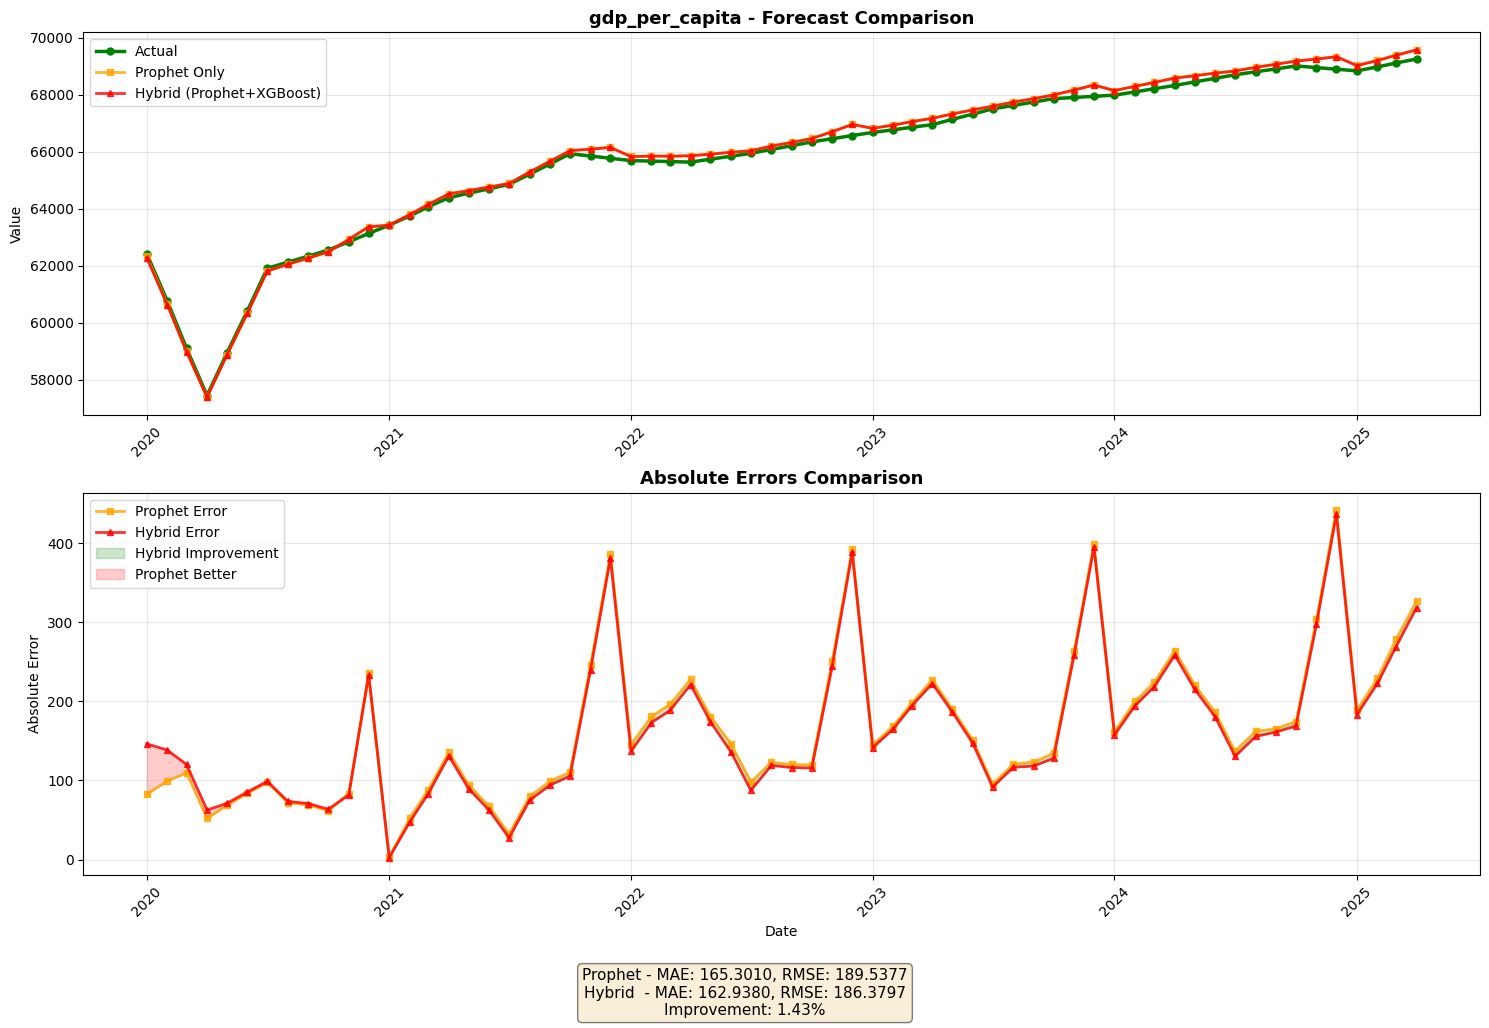


HYBRID FORECASTING COMPLETE
Successfully forecasted 12 indicators

SUMMARY METRICS:
Indicator            Prophet MAE  Hybrid MAE   Improvement  XGBoost Used
--------------------------------------------------------------------
1_year_rate          0.1461       0.1461       0.00        % No          
3_months_rate        0.3240       0.3261       -0.62       % Yes         
6_months_rate        0.0732       0.0755       -3.03       % Yes         
CPI                  25.2010      25.2283      -0.11       % Yes         
INDPRO               7.3688       7.3834       -0.20       % Yes         
10_year_rate         0.1517       0.1527       -0.64       % Yes         
share_price          11.2883      11.3672      -0.70       % Yes         
unemployment_rate    2.1051       2.1178       -0.61       % Yes         
PPI                  152.2293     152.3258     -0.06       % Yes         
OECD_CLI_index       0.1732       0.1757       -1.41       % Yes         
CSI_index            20.2434     

In [2]:
train_df = pd.read_csv('../data/fix/feature_selected_recession_train.csv')
test_df = pd.read_csv('../data/fix/feature_selected_recession_test.csv')

all_results, forecasted = run_hybrid_forecasting(
    train_df, test_df, 
    financial_indicators=financial_indicators,
    n_trials_prophet=20,  # Fewer trials since Prophet is slower
    n_trials_xgb=20,      # XGBoost trials on residuals
    plot_results=True
)